# Variant 2-15 Normal vs non-parametric Bayes classifier

## Read data

In [152]:
# !pip install KDEpy #for google colab
from typing import Dict
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from sklearn.model_selection import KFold
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from KDEpy.bw_selection import improved_sheather_jones
NUM_CLASSES = 4
data = pd.read_csv('lab2/data_ml_v2-15.csv') # load the data
X = data.iloc[:, :-1].values # extract the features
y = data.iloc[:, -1].values # extract the labels

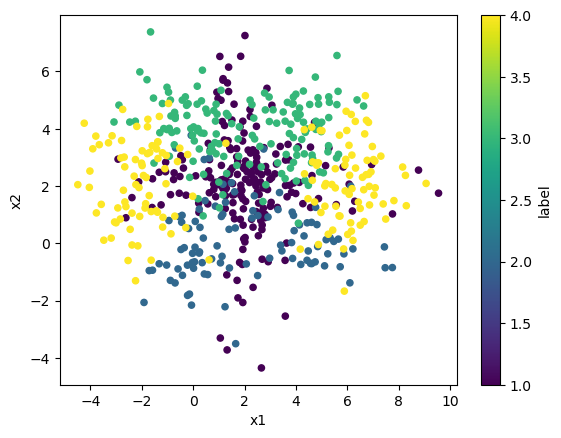

In [42]:
data.plot.scatter(x='x1', y='x2', c='label', colormap='viridis');

## 1. Estimate the covariance matrices of the training data for each class under different assumptions:

a) covariance matrices of all classes are equal, scalar;

b) equal, diagonal;

c) different, scalar;

d) different, diagonal;

e) equal;

f) different.

**Visualize matrices for each case.**

a) Covariance matrices of all classes are equal and scalar

Equation:

$$\sum_{equal\ scalar} = \frac{1}{N-K}\sum_{i=1}^{K}(\sum_{j=1}^{N_i}(x_{j} - \mu_i)(x_{j} - \mu_i)^T)_{mean} * n_i * I$$

In [3]:
def shared_scalar_cov_matrix(X, y):
    class_data_list = [X[y == i+1] for i in range(NUM_CLASSES)]
    return np.sum([np.cov(class_data.T).mean() * class_data.shape[0] * np.eye(class_data.shape[1]) 
                   for class_data in class_data_list], axis=0) / (X.shape[0] - NUM_CLASSES)

b) Covariance matrices of all classes are equal and diagonal

Equation:

$$\sum_{equal\ diagonal} = \frac{1}{N-K}\sum_{i=1}^{K}diag(\sum_{j=1}^{N_i}(x_{j} - \mu_i)(x_{j} - \mu_i)^T)_{mean} * n_i$$

In [4]:
def shared_diagonal_cov_matrix(X, y):
    class_data_list = [X[y == i+1] for i in range(NUM_CLASSES)]
    return np.sum([np.diag(np.cov(class_data.T).mean(axis=0)) * class_data.shape[0]
                   for class_data in class_data_list], axis=0) / (X.shape[0] - NUM_CLASSES)

c) Covariance matrices of all classes are different and scalar

Equation:

$$\sum_{different\ scalar} = \frac{1}{N-K}\sum_{i=1}^{K}(\frac{(\sum_{j=1}^{N_i}(x_{j} - \mu_i)(x_{j} - \mu_i)^T)}{n_i})_{reverced} * I$$

In [5]:
def different_scalar_cov_matrices(X, y):
    # different_scalar_cov_matrices = [np.sum([(x - class_mean)[:, np.newaxis].dot((x - class_mean)[np.newaxis, :])[::-1] * class_data.shape[0] * np.eye(class_data.shape[1]) for x in class_data], axis=0) / (X_train.shape[0] - NUM_CLASSES) for class_mean, class_data in zip(class_means, class_data_list)]
    class_data_list = [X[y == i+1] for i in range(NUM_CLASSES)]
    return [np.abs(np.sum([np.cov(class_data.T, bias=True)
                    for _ in class_data], axis=0)[::-1] * class_data.shape[0] * np.eye(class_data.shape[1]) / (X.shape[0] - NUM_CLASSES))
            for class_data in class_data_list]

d) Covariance matrices of all classes are different and diagonal

Equation:

$$\sum_{different\ diagonal} = \frac{1}{N-K}\sum_{i=1}^{K}diag(\frac{\sum_{j=1}^{N_i}(x_{j} - \mu_i)(x_{j} - \mu_i)^T}{n_i})$$

In [6]:
def different_diag_cov_matrices(X, y):
    # different_diag_cov_matrices = [np.diag(np.sum([(x - class_mean)[:, np.newaxis].dot((x - class_mean)[np.newaxis, :]) / class_data.shape[0] for x in class_data], axis=0)) for class_mean, class_data in zip(class_means, class_data_list)]
    class_data_list = [X[y == i+1] for i in range(NUM_CLASSES)]
    return np.array([np.sum([np.diag(np.cov(class_data.T, bias=True)) / class_data.shape[0] 
                             for _ in class_data], axis=0) * np.eye(class_data.shape[1]) / (X.shape[0] - NUM_CLASSES) 
                     for class_data in class_data_list])

e) Covariance matrices of all classes are equal 

Equation:
$$\sum_{equal} = \frac{1}{N}\sum_{i=1}^{N}(x_{i} - \mu)(x_{i} - \mu)^T$$

In [7]:
def shared_cov_matrix(X, y):
    return np.cov(X.T, bias=True) / NUM_CLASSES
    # return np.sum([np.cov(class_data.T) * class_data.shape[0] for class_data in class_data_list], axis=0) / (X.shape[0] - NUM_CLASSES)

f) Covariance matrices of all classes are different

Equation:

$$\sum_{different} = \{\sum_{1}, \sum_{2}, ..., \sum_{K}\}$$

In [8]:
def different_cov_matrices(X, y):
    class_data_list = [X[y == i+1] for i in range(NUM_CLASSES)]
    return np.array([np.cov(class_data.T) / NUM_CLASSES for class_data in class_data_list])

## 1.1. Visualize the covariance matrices for each case.

In [164]:
# bayes classifier
def bayes_classifier(x, cov_matrices, X_train, y_train, class_probs):
    probs = np.zeros((NUM_CLASSES,))
    for i in range(NUM_CLASSES):
        probs[i] = multivariate_normal.pdf(x, mean=np.mean(X_train[y_train == i+1], axis=0), cov=cov_matrices[i], allow_singular=True)
    posterior_probs = probs * class_probs / np.sum(probs * class_probs)
    return posterior_probs

# train test split with 5-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

train_scores = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}
test_scores = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}

train_preds = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}
test_preds = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}

cov_matrices = {'a':[], 'b':[], 'c':[], 'd':[], 'e':[], 'f':[]}

# apriori class probabilities
class_probs = np.ones((NUM_CLASSES,)) / NUM_CLASSES

for train_index, test_index in kf.split(X):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    
    # calculate covariance matrices
    cov_matrices['a'].append([shared_scalar_cov_matrix(X_train, y_train)] * NUM_CLASSES)
    cov_matrices['b'].append([shared_diagonal_cov_matrix(X_train, y_train)] * NUM_CLASSES)
    cov_matrices['c'].append(different_scalar_cov_matrices(X_train, y_train))
    cov_matrices['d'].append(different_diag_cov_matrices(X_train, y_train))
    cov_matrices['e'].append([shared_cov_matrix(X_train, y_train)] * NUM_CLASSES)
    cov_matrices['f'].append(different_cov_matrices(X_train, y_train))
    
    # get predictions and scores
    for key in cov_matrices.keys():
        train_preds[key].append([bayes_classifier(x, cov_matrices[key][-1], X_train, y_train, class_probs) for x in X_train])
        test_preds[key].append([bayes_classifier(x, cov_matrices[key][-1], X_train, y_train, class_probs) for x in X_test])
        train_scores[key].append(np.mean([np.argmax(train_preds[key][-1][i]) + 1 == y_train[i] for i in range(len(y_train))]))
        test_scores[key].append(np.mean([np.argmax(test_preds[key][-1][i]) + 1 == y_test[i] for i in range(len(y_test))]))

/var/folders/k0/pk1b16mx61j0c8lv8m_l5gl40000gn/T/ipykernel_3728/3480657004.py:6: RuntimeWarning: invalid value encountered in true_divide
  posterior_probs = probs * class_probs / np.sum(probs * class_probs)


In [165]:
def plot_cov_matrixes(cov_matrices, title):
    """cov_matrices: list of covariance matrices per class"""
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(cov_matrices[i], interpolation='nearest')
        ax.set_title(f'Class {i+1}')
        # add colorbar
        ax.figure.colorbar(ax.images[0], ax=ax)
        # add values to each cell
        for (j,k),label in np.ndenumerate(cov_matrices[i]):
            ax.text(k, j, np.round(label, 5), ha='center', va='center', color='r')
    fig.suptitle(title)
    plt.show()

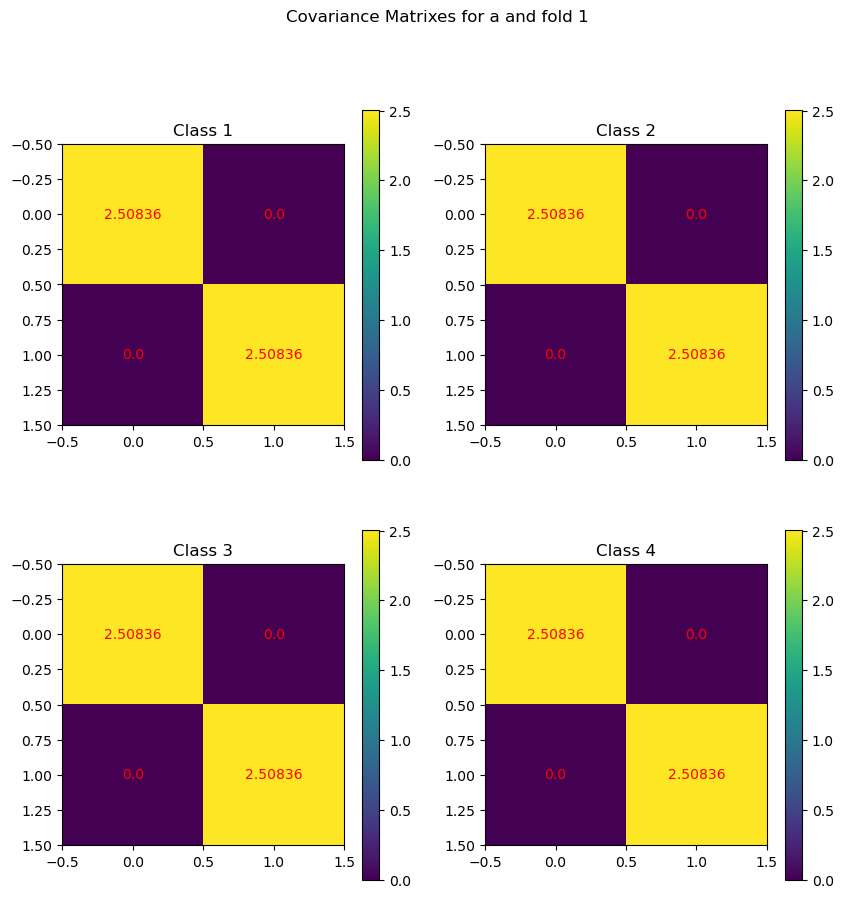

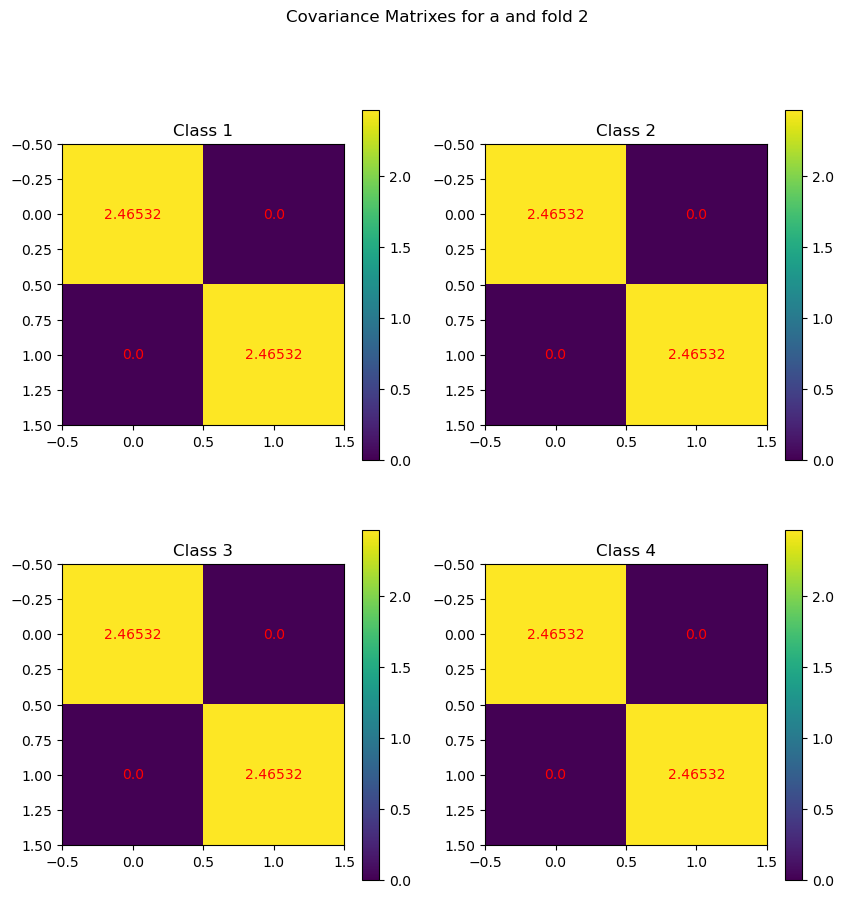

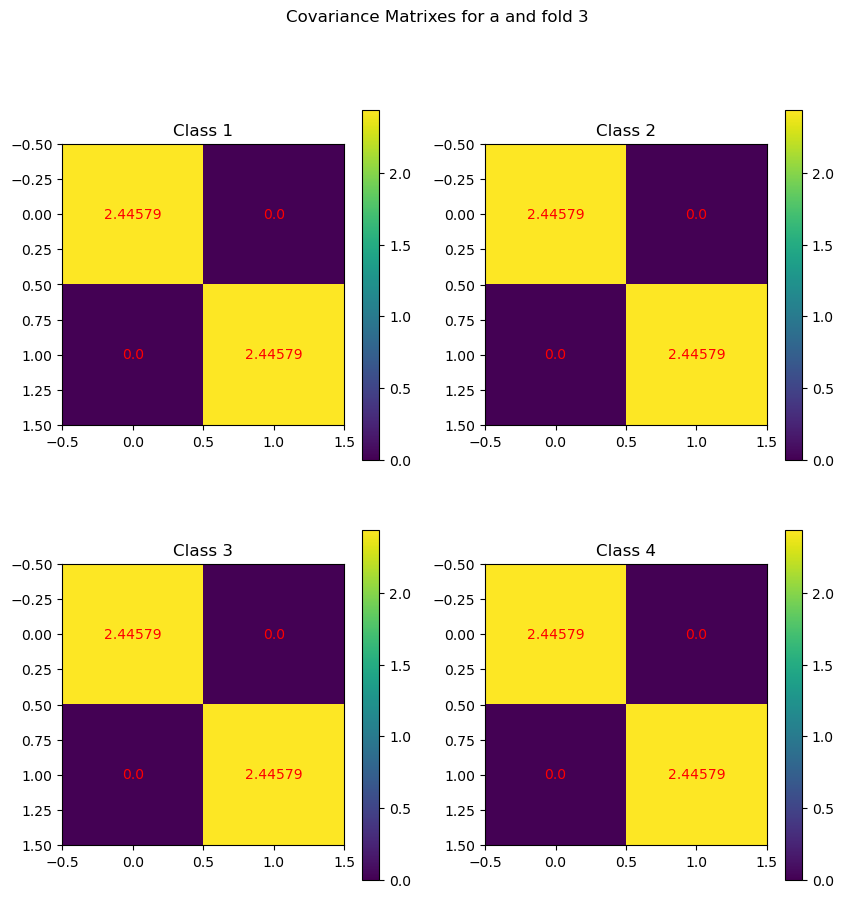

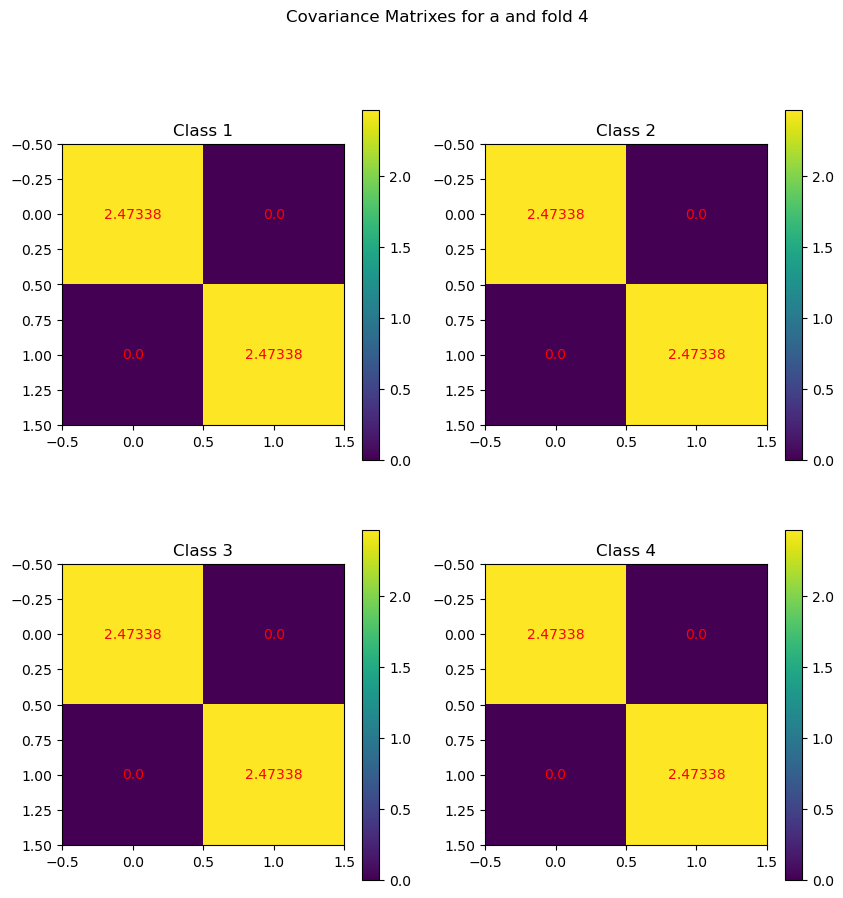

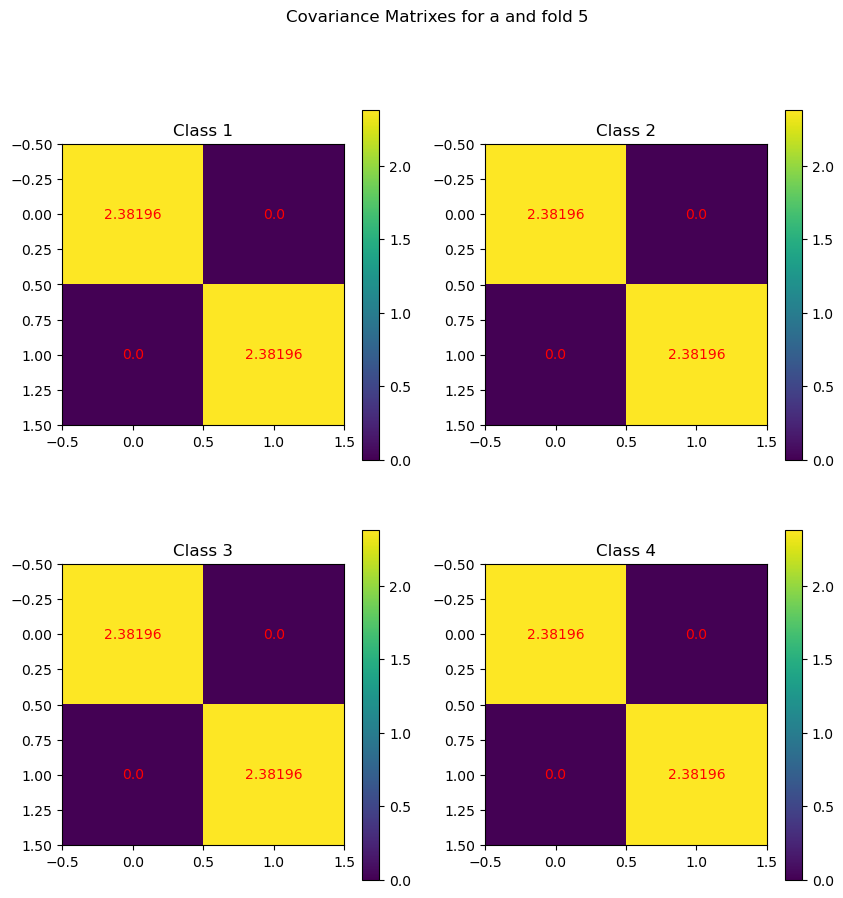

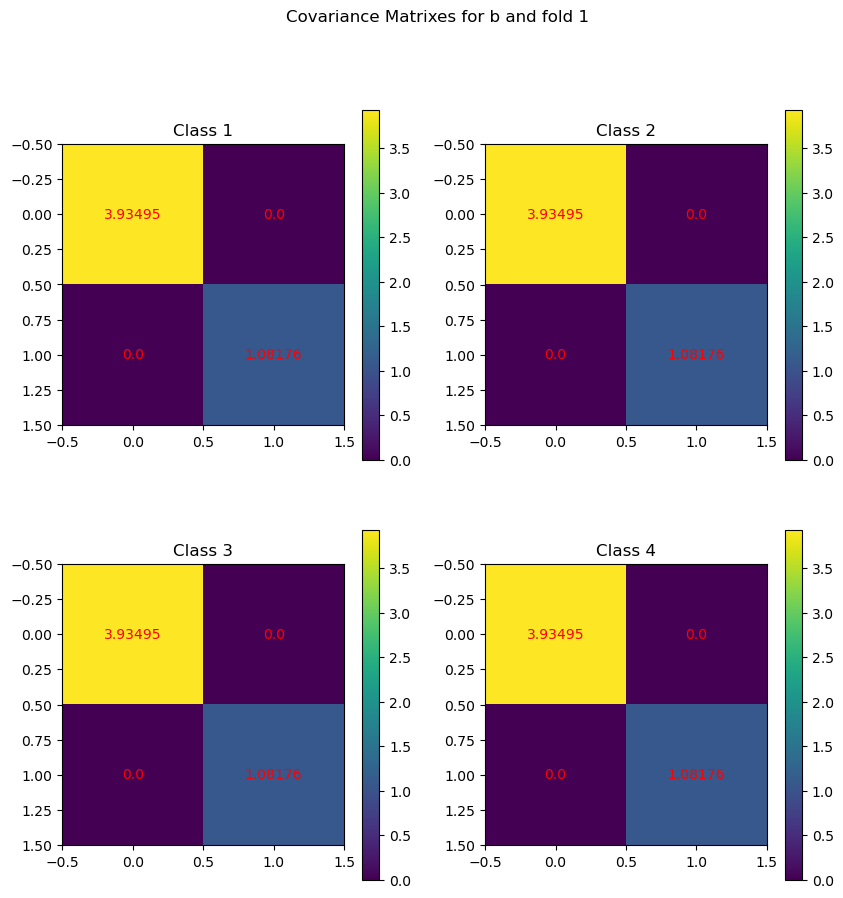

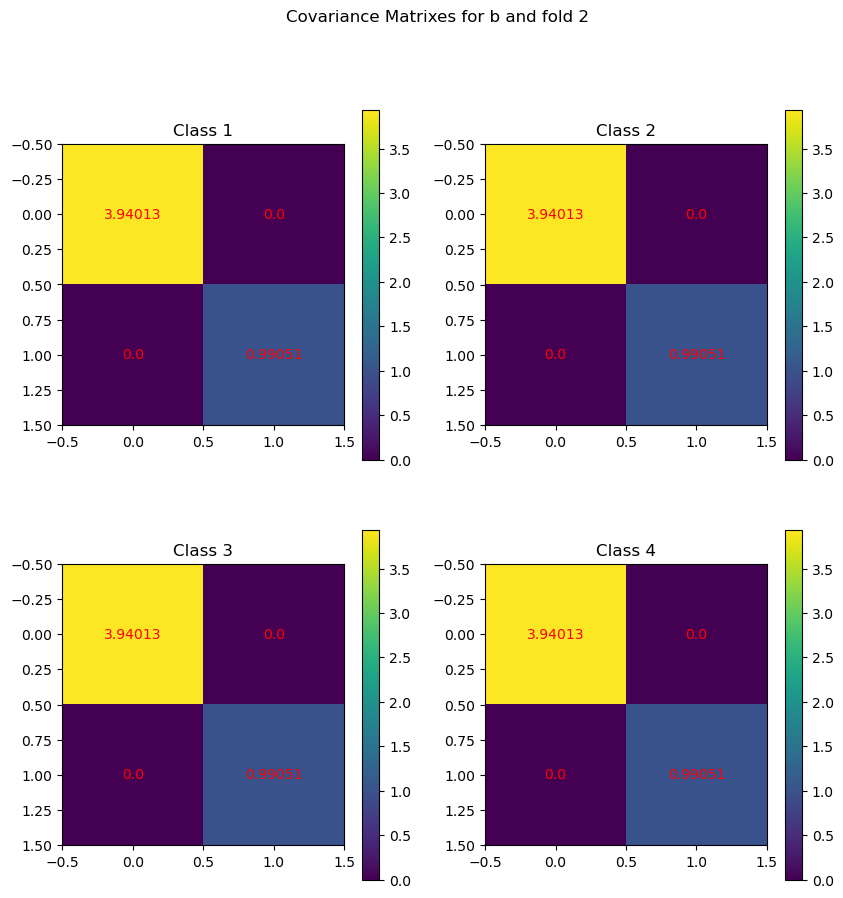

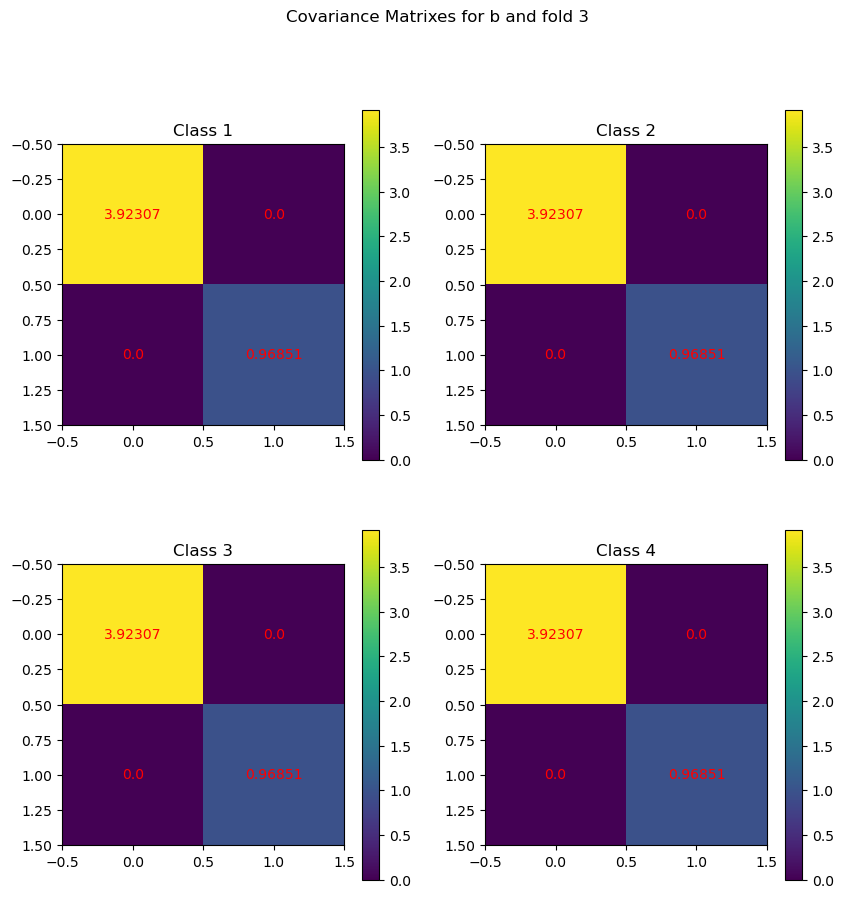

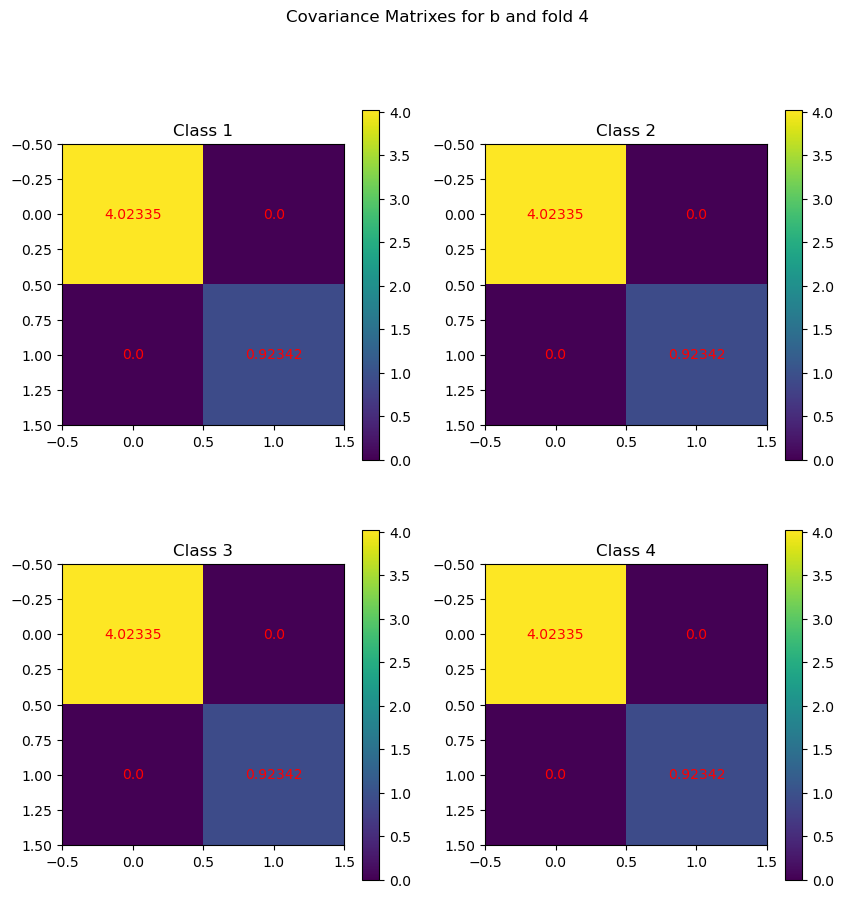

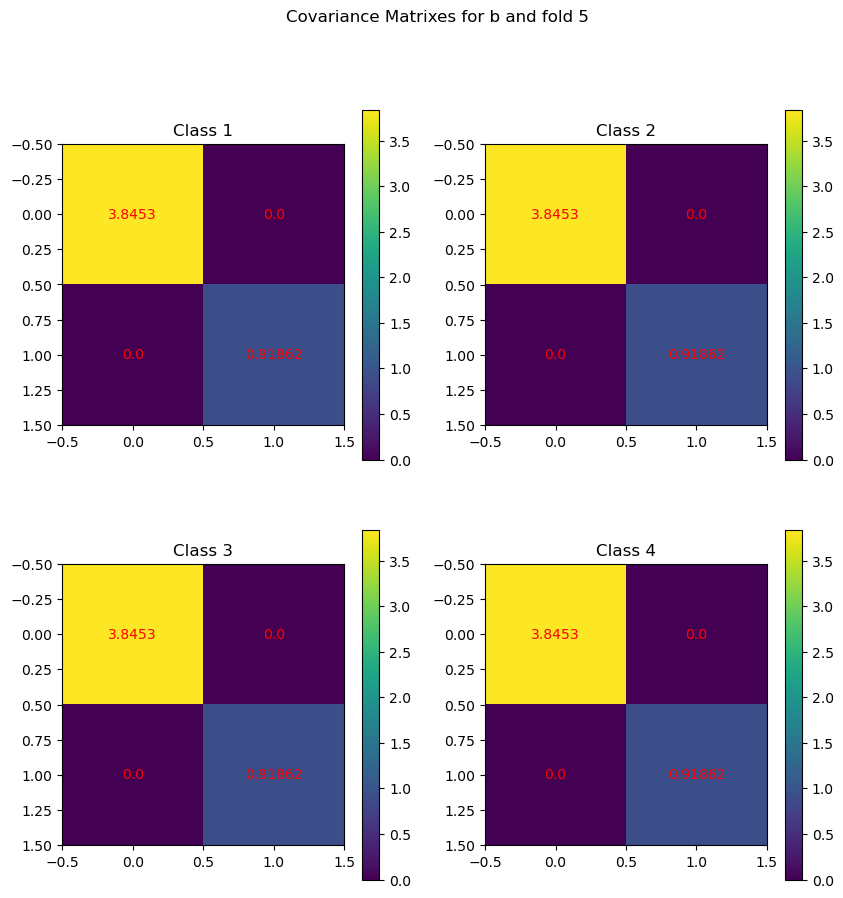

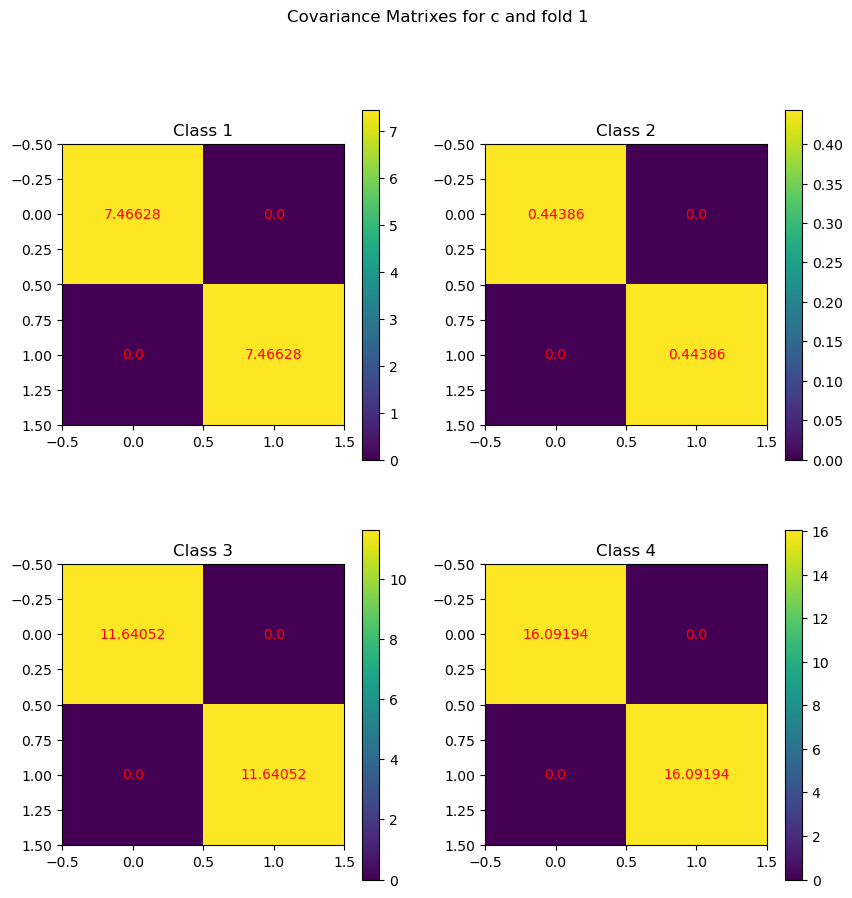

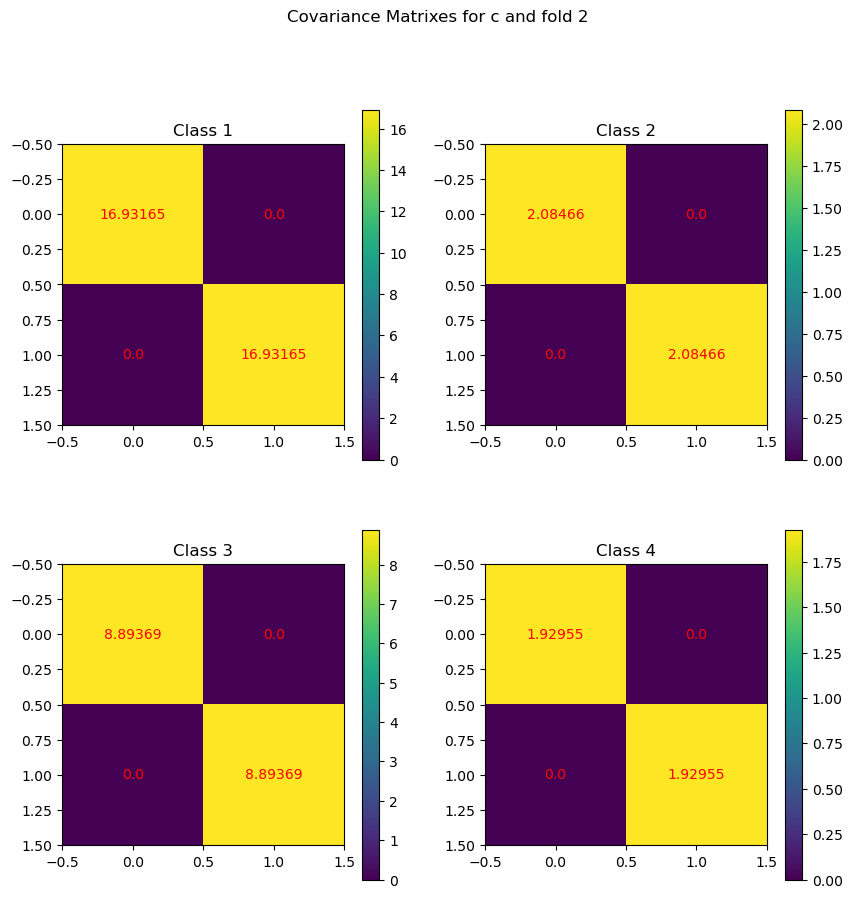

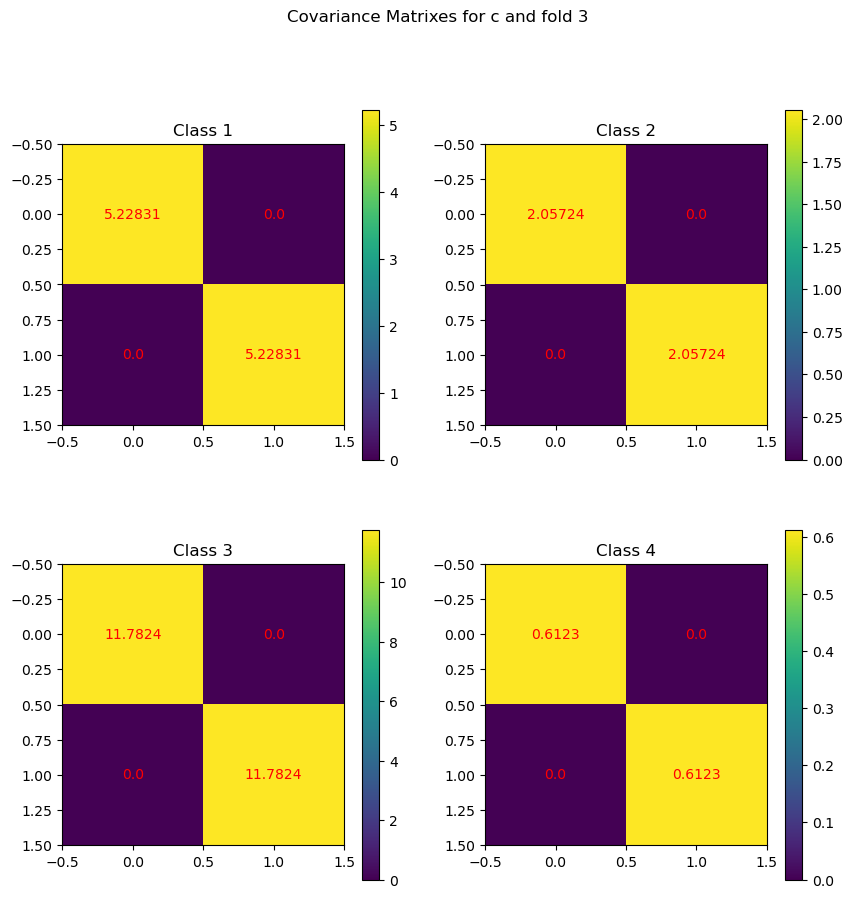

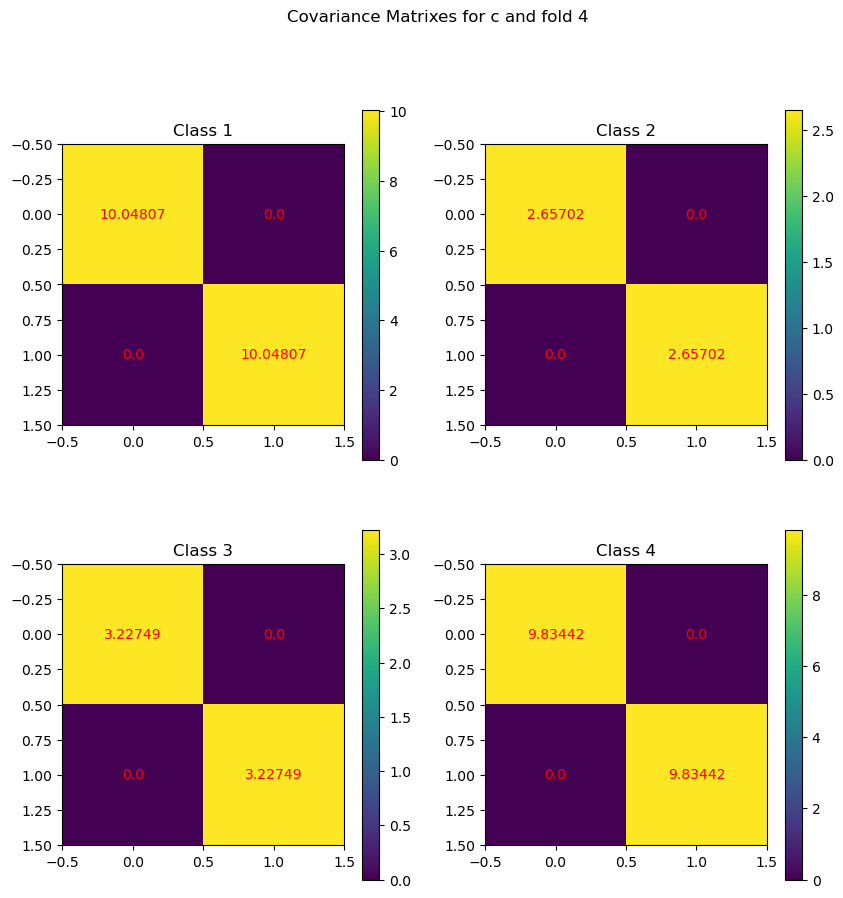

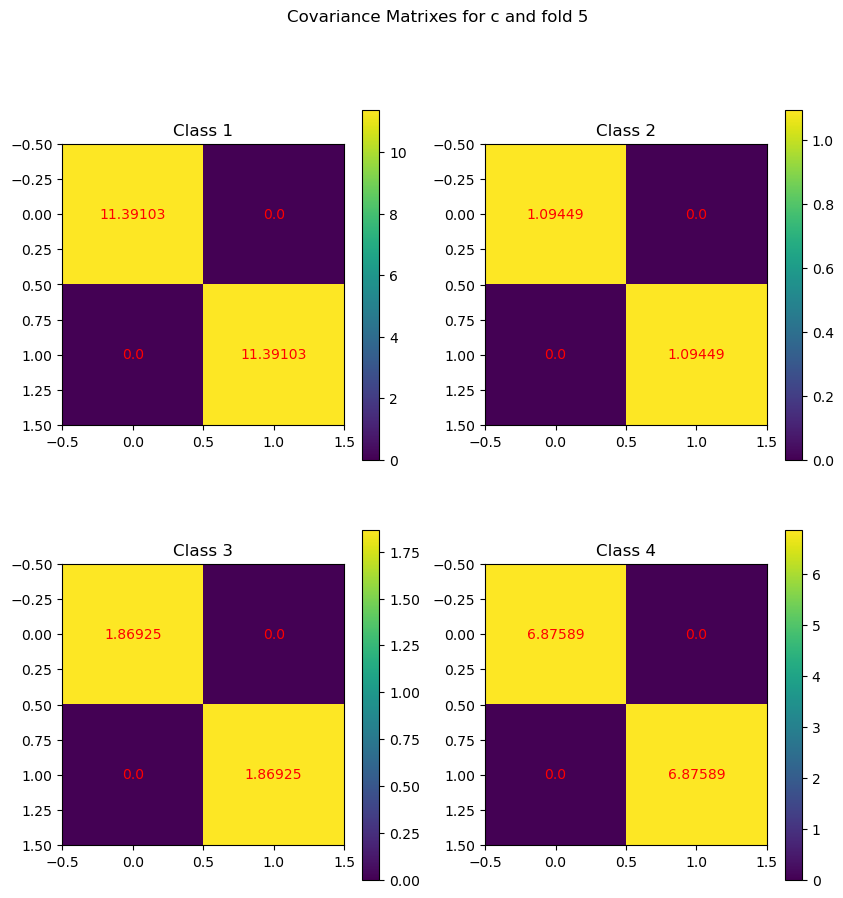

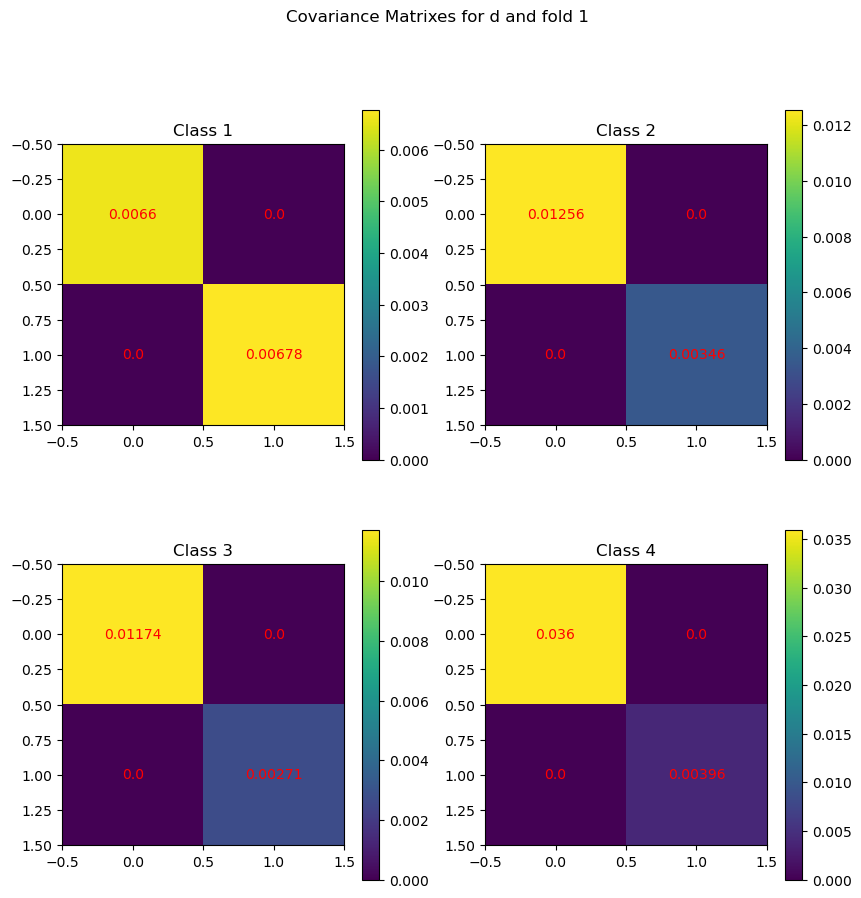

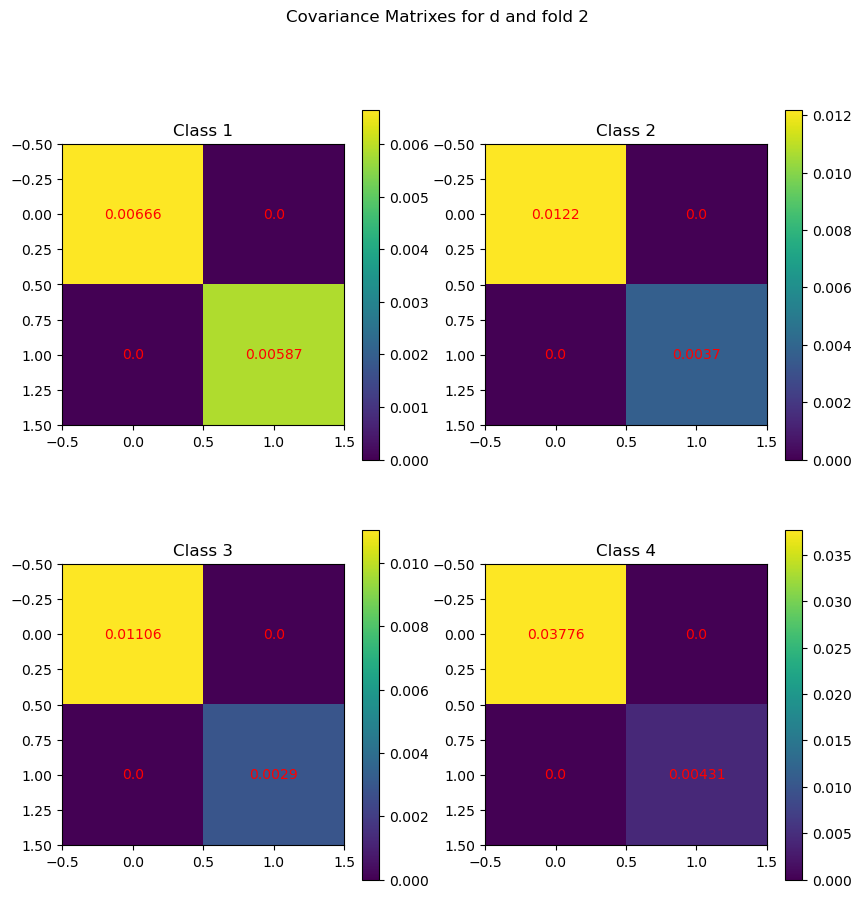

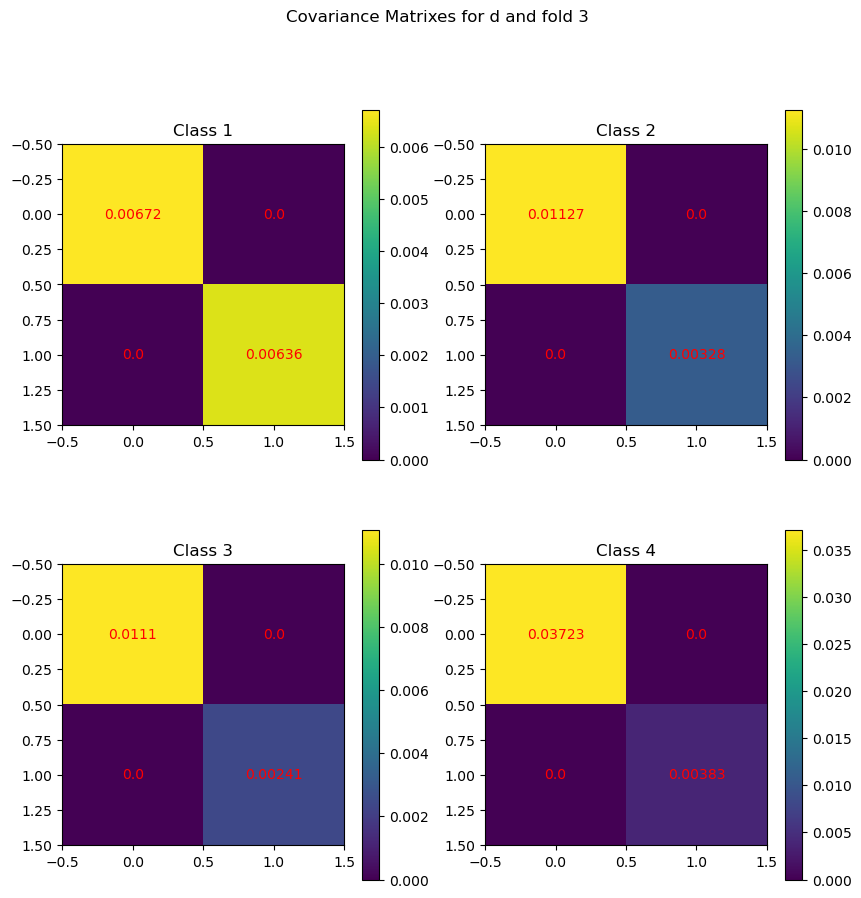

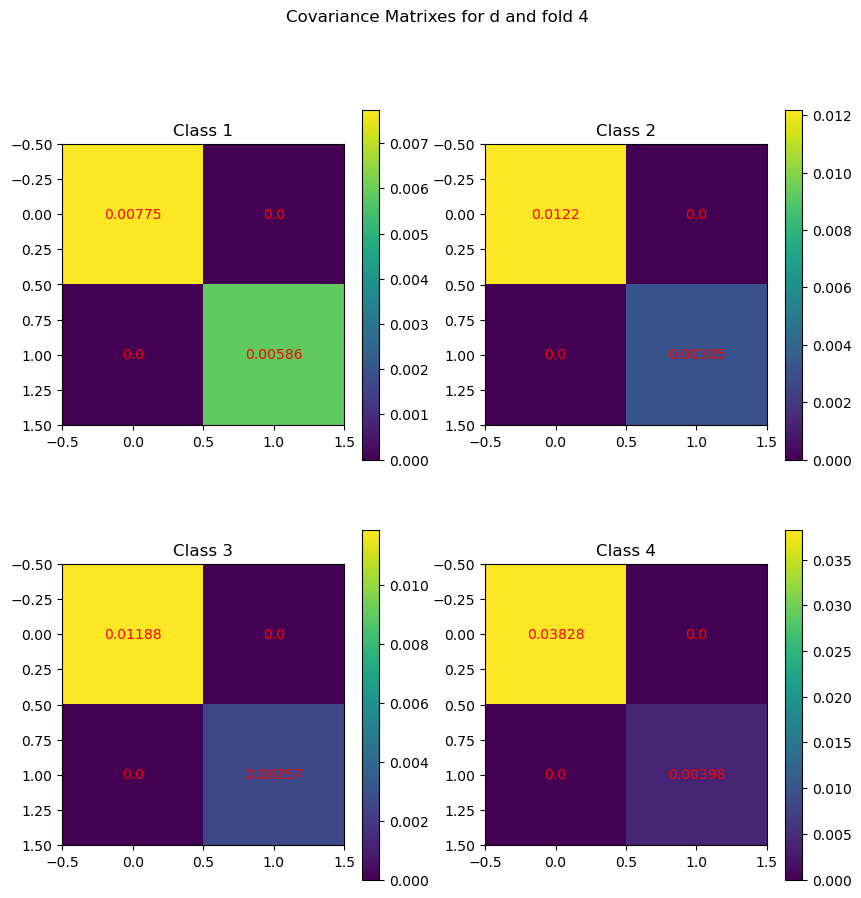

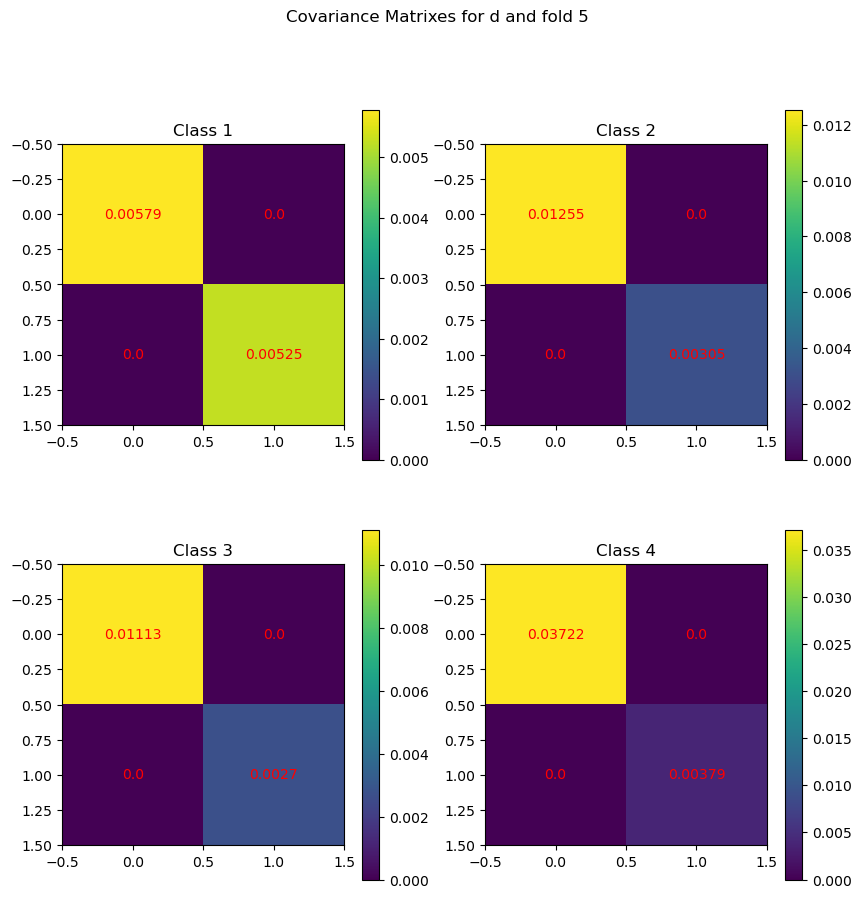

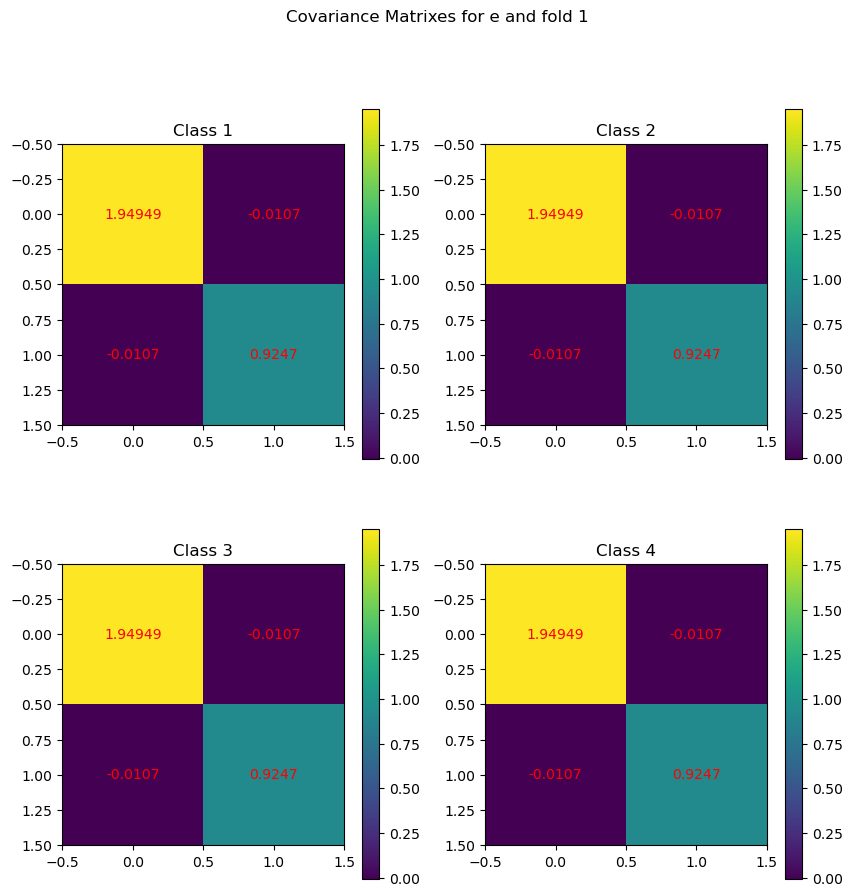

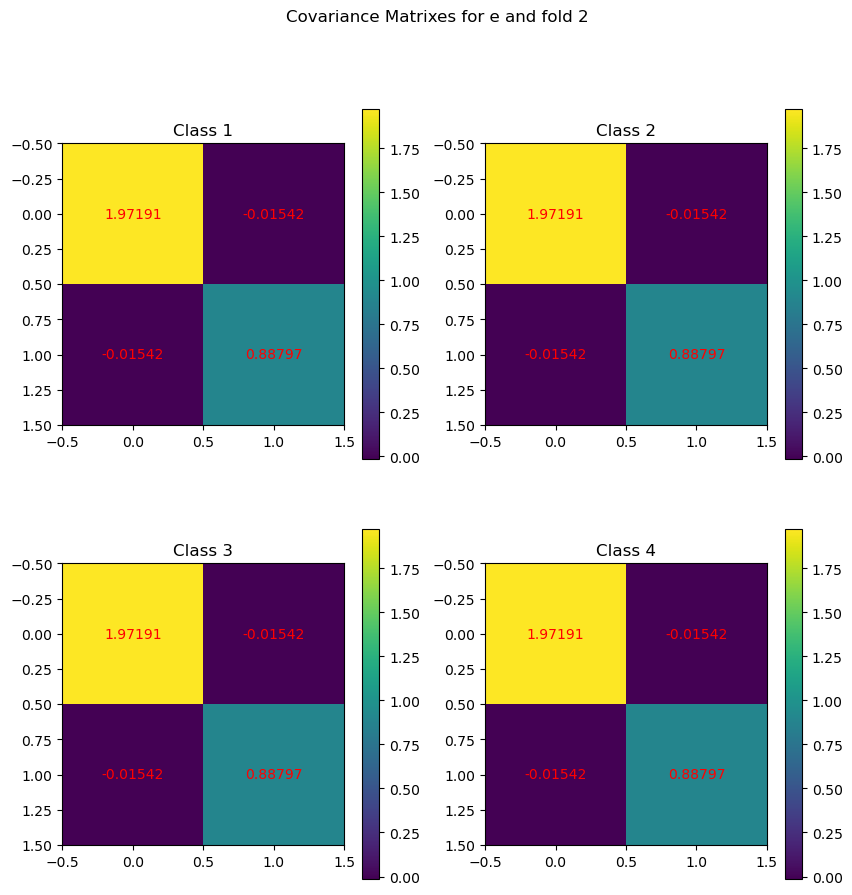

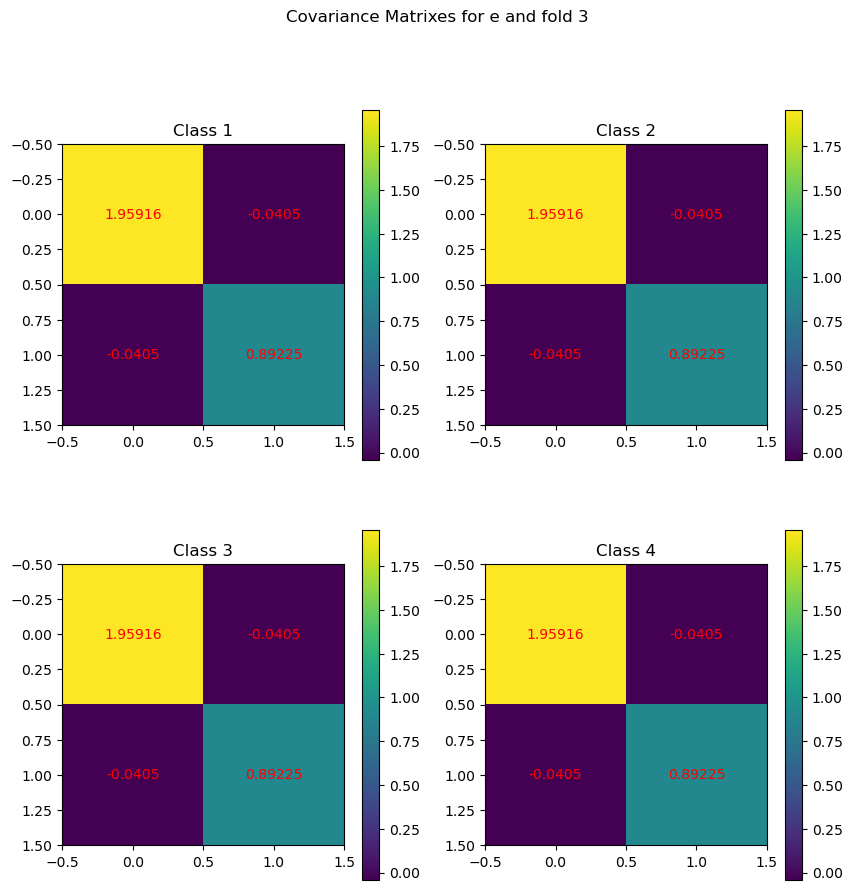

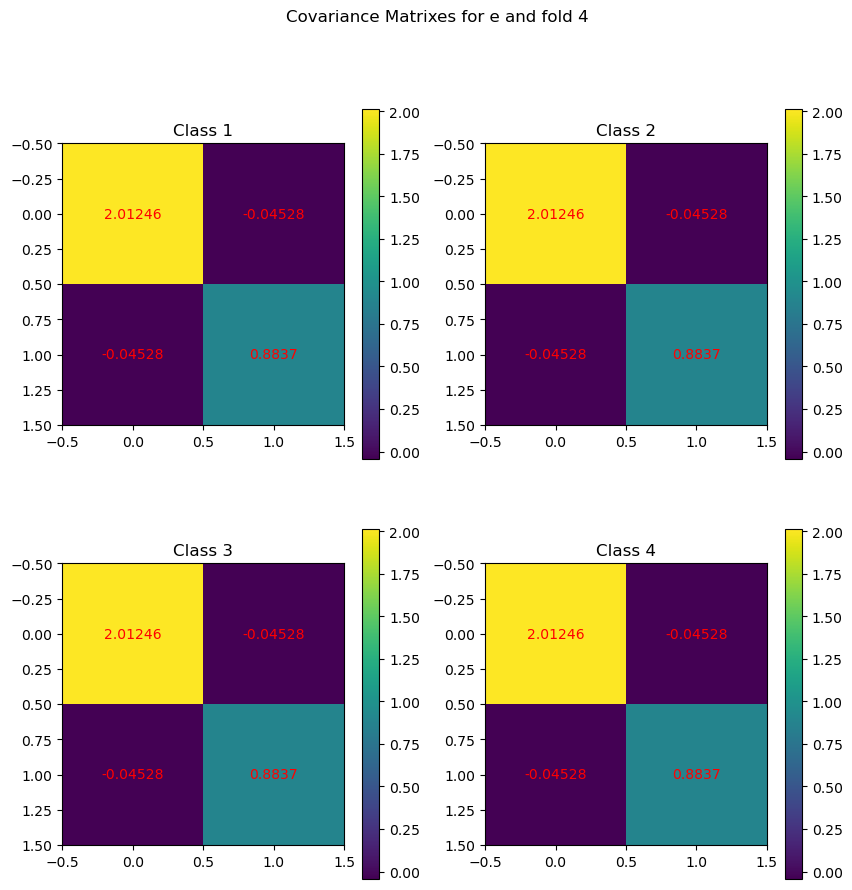

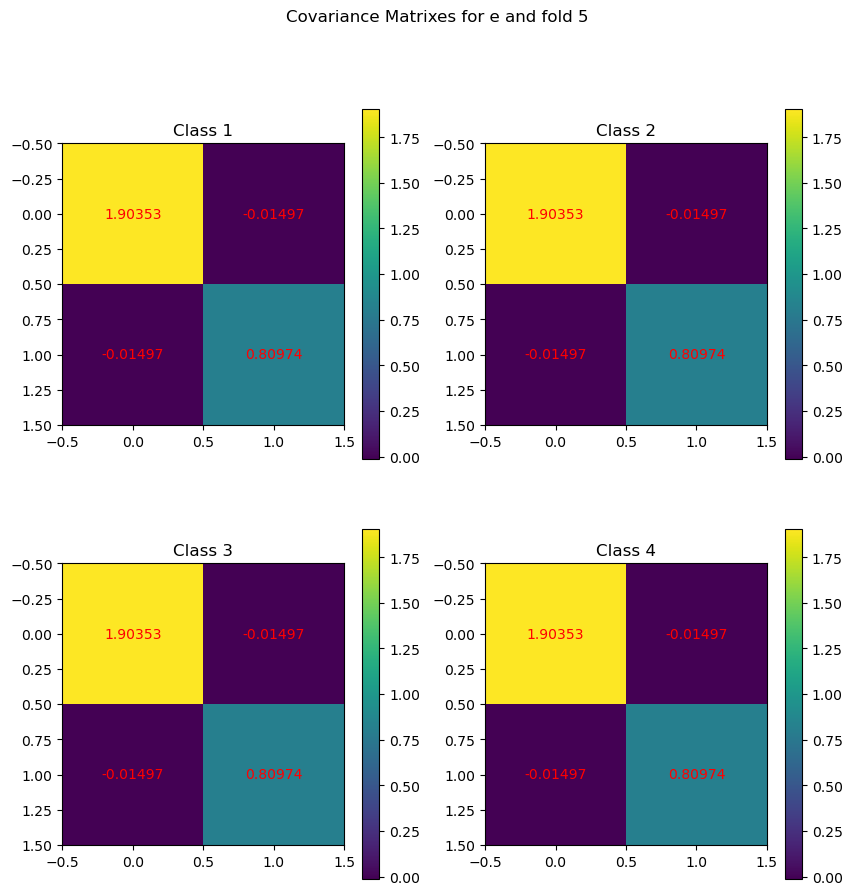

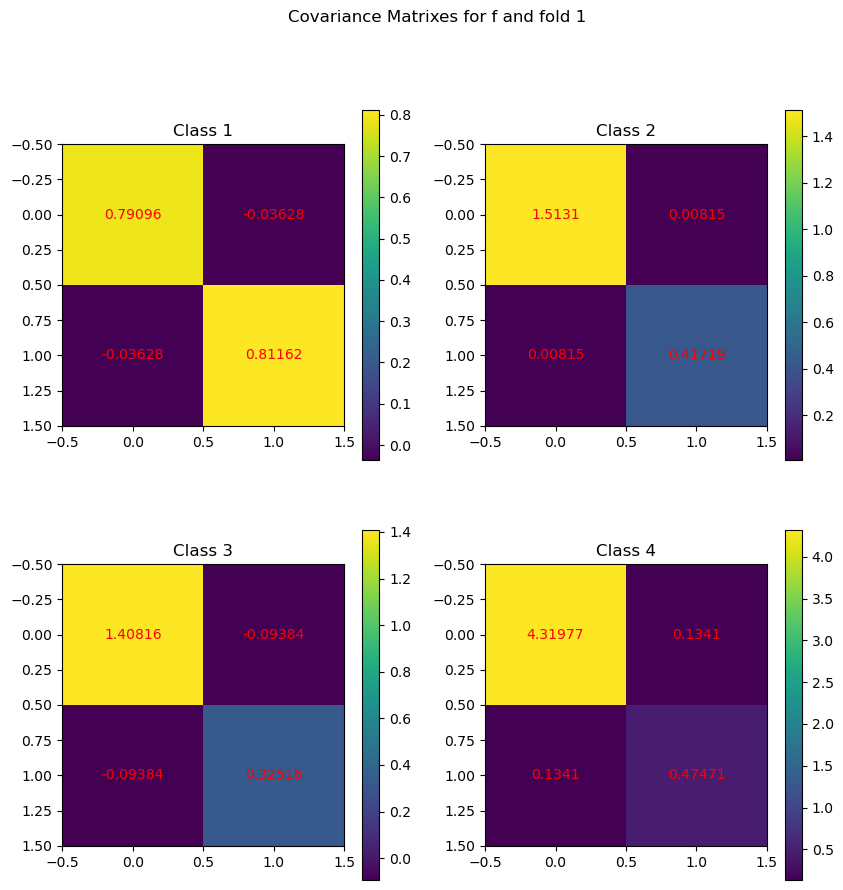

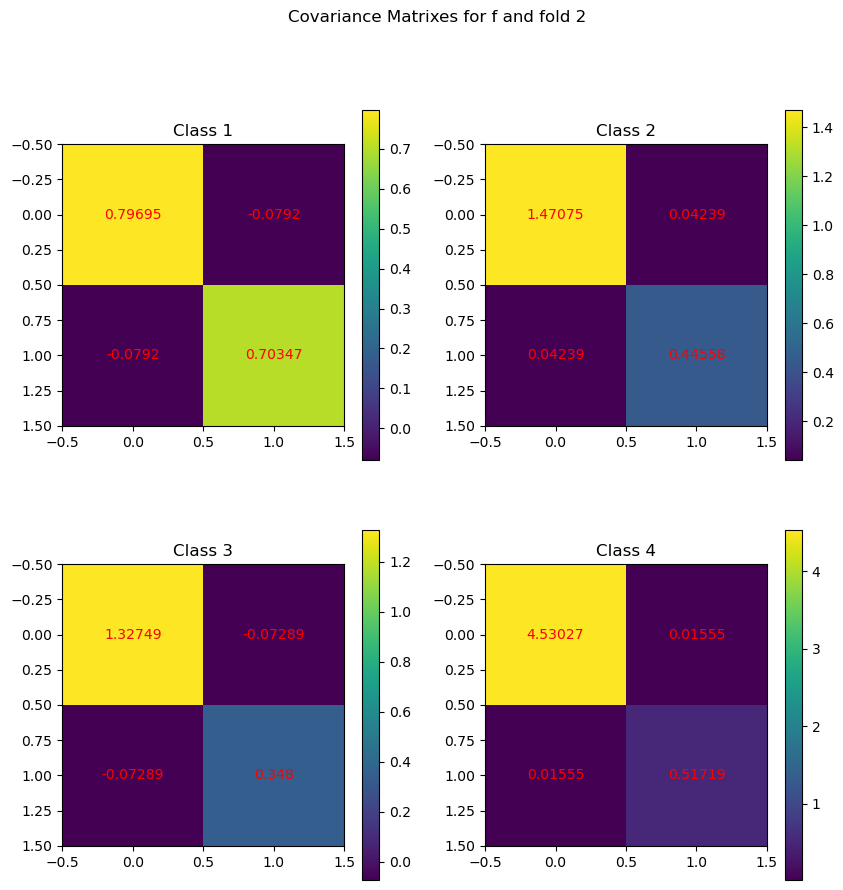

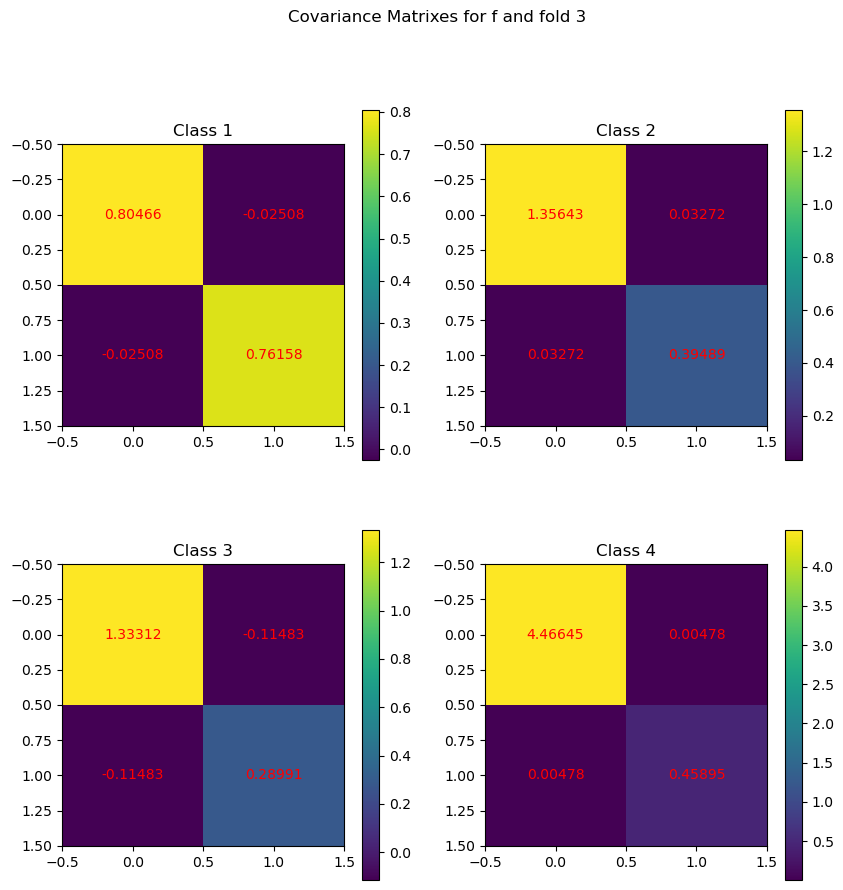

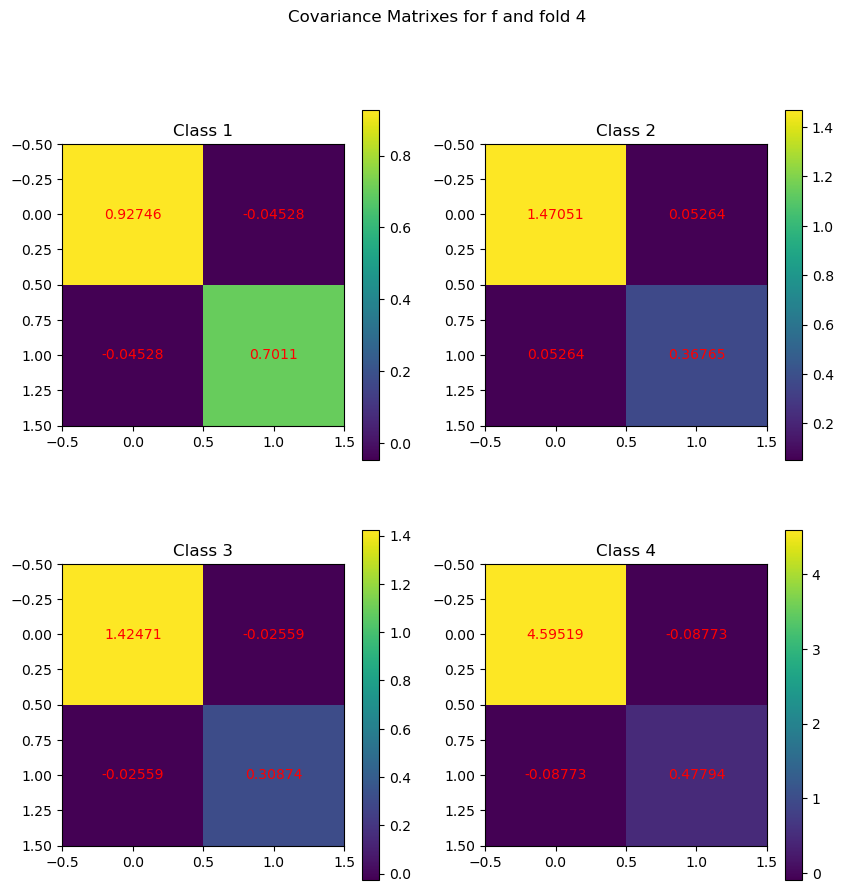

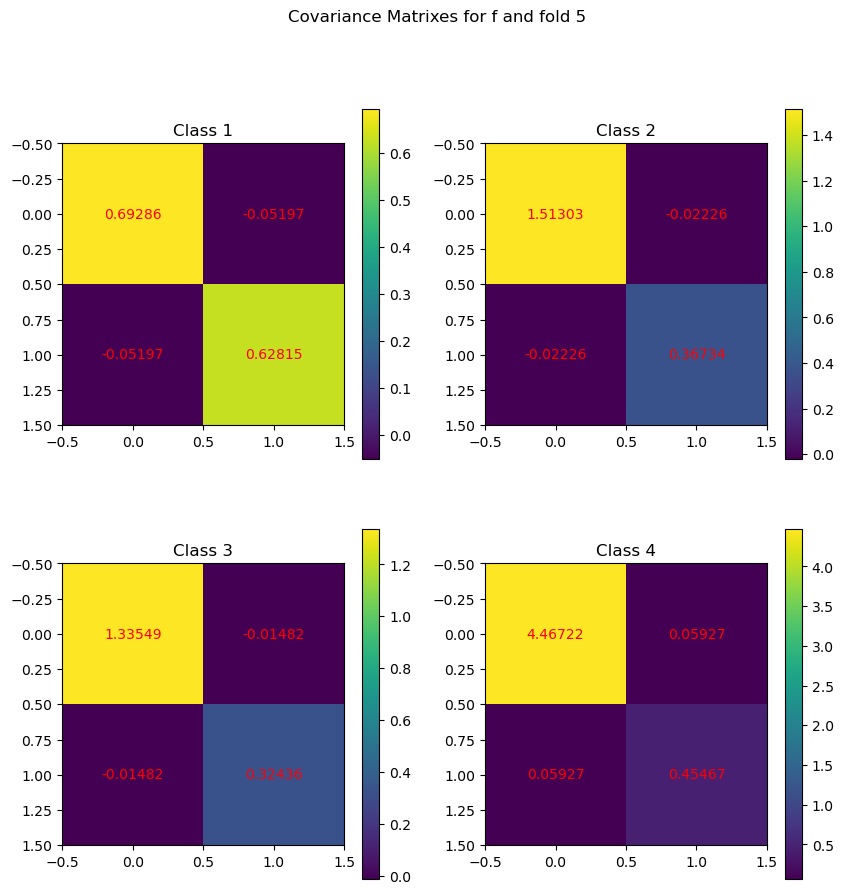

In [166]:
for key in cov_matrices.keys():
    for fold in range(5):
        plot_cov_matrixes(cov_matrices[key][fold], f'Covariance Matrixes for {key} and fold {fold+1}')

## 2. Calculate the classification scores of the trained Bayesian classifiers (under the assumptions from step 1) for the examples of training and test sets.

$$ P(y|x) = \frac{P(x|y)P(y)}{P(x)}$$

$$ P(y|x) = \frac{P(x|y)P(y)}{\sum_{i=1}^{K}P(x|y_i)P(y_i)}$$

A priori probabilities of classes are considered equal
$$ P(y) = \frac{1}{N}$$

$$ P(x|y) = \frac{1}{(2\pi\det\sum)^{n/2}}exp(-\frac{1}{2}(x-\mu_{y})^T\sum^{-1}(x-\mu_{y}))$$

This formula programmed in scipy.stats.multivariate_normal.pdf

To get posterior probabilities we can use `bayes_classifier` function.

In [45]:
for key in cov_matrices.keys():
    train_prob_per_fold = []
    test_prob_per_fold = []
    for fold in range(5):
        train_prob_per_fold.append(np.nanmean(np.array(train_preds[key][fold]), axis=0))
        test_prob_per_fold.append(np.nanmean(np.array(test_preds[key][fold]), axis=0))
    print(f' Train points per class for assumption {key}:\n',
          *np.round(np.mean(np.array(train_prob_per_fold), axis=0), 3), '\n',
          f'Test points per class for assumption {key}:\n',
          *np.round(np.mean(np.array(test_prob_per_fold), axis=0), 3), '\n',
          f'Train Accuracy {np.mean(train_scores[key]):.3f} \u00B1 {np.std(train_scores[key]):.3f}', '\n',
          f'Test Accuracy {np.mean(test_scores[key]):.3f} \u00B1 {np.std(test_scores[key]):.3f}',
          sep=' ')

 Train points per class for assumption a:
 0.261 0.216 0.26 0.263 
 Test points per class for assumption a:
 0.263 0.22 0.26 0.257 
 Train Accuracy 0.497 ± 0.028 
 Test Accuracy 0.468 ± 0.040
 Train points per class for assumption b:
 0.236 0.232 0.297 0.235 
 Test points per class for assumption b:
 0.237 0.234 0.297 0.232 
 Train Accuracy 0.502 ± 0.027 
 Test Accuracy 0.470 ± 0.040
 Train points per class for assumption c:
 0.307 0.154 0.282 0.257 
 Test points per class for assumption c:
 0.314 0.151 0.276 0.258 
 Train Accuracy 0.368 ± 0.072 
 Test Accuracy 0.368 ± 0.075
 Train points per class for assumption d:
 0.072 0.187 0.242 0.499 
 Test points per class for assumption d:
 0.069 0.181 0.242 0.507 
 Train Accuracy 0.520 ± 0.017 
 Test Accuracy 0.510 ± 0.039
 Train points per class for assumption e:
 0.233 0.233 0.3 0.234 
 Test points per class for assumption e:
 0.234 0.237 0.3 0.228 
 Train Accuracy 0.500 ± 0.028 
 Test Accuracy 0.477 ± 0.041
 Train points per class for assu

### Prob and acc per fold

In [13]:
for key in cov_matrices.keys():
    for fold in range(5):
        print(f'Train points per class for assumption {key} and fold {fold + 1}:\n', 
              np.nanmean(np.array(train_preds[key][fold]), axis=0), '\n',
              f'Test points per class for assumption {key} and fold {fold + 1}:\n',
              np.nanmean(np.array(test_preds[key][fold]), axis=0), '\n',
              'Train Accuracy', train_scores[key][fold], '\n',
              'Test Accuracy', test_scores[key][fold])

Train points per class for assumption a and fold 1:
 [0.25493684 0.2176994  0.25889411 0.26846966] 
 Test points per class for assumption a and fold 1:
 [0.26987098 0.2298373  0.24665711 0.25363461] 
 Train Accuracy 0.5333333333333333 
 Test Accuracy 0.4666666666666667
Train points per class for assumption a and fold 2:
 [0.26134883 0.21324556 0.26395603 0.26144958] 
 Test points per class for assumption a and fold 2:
 [0.26291415 0.22640445 0.24710792 0.26357348] 
 Train Accuracy 0.4666666666666667 
 Test Accuracy 0.4666666666666667
Train points per class for assumption a and fold 3:
 [0.2625551  0.22291615 0.25532583 0.25920292] 
 Test points per class for assumption a and fold 3:
 [0.27146459 0.17551524 0.28983224 0.26318792] 
 Train Accuracy 0.4625 
 Test Accuracy 0.44166666666666665
Train points per class for assumption a and fold 4:
 [0.26181437 0.21544444 0.2607675  0.26197369] 
 Test points per class for assumption a and fold 4:
 [0.26017849 0.21498594 0.26474093 0.26009464] 
 

## 3. Calculate the accuracy of the built classifiers on the training and test samples, present the data in a graphical form (bar charts)

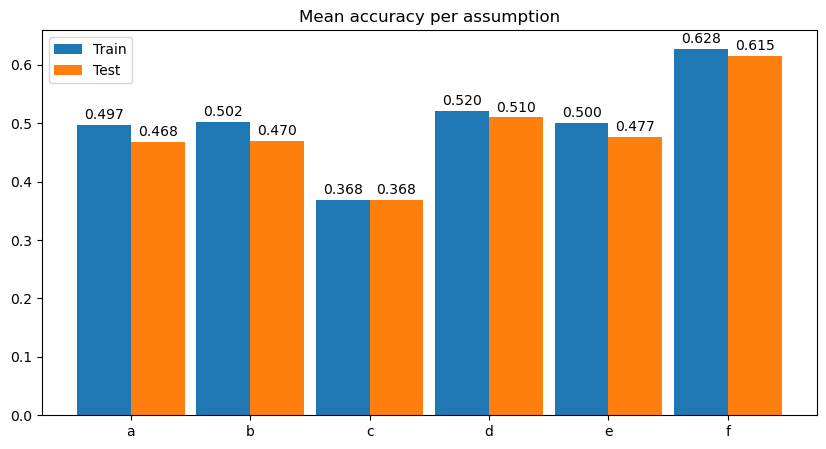

In [46]:
plt.figure(figsize=(10, 5))
ax = plt.axes()
label_location = np.arange(len(train_scores.keys()))
width = 0.45
multiplier = 0
for plot_data, name in zip([train_scores, test_scores], ['Train', 'Test']):
    bar = ax.bar([i + width * multiplier for i in label_location], 
                 [np.mean(plot_data[key]) for key in plot_data.keys()], 
                 width=width, label=name, align='edge',
                 )
    ax.bar_label(bar, padding=2, fmt='%.3f')
    multiplier += 1
ax.legend()
ax.set_title('Mean accuracy per assumption')
ax.set_xticks([i + width for i in label_location], plot_data.keys())
plt.show();

## 4. Assuming the independence of the Parzen kernels, visualize the reconstructed two-dimensional distribution densities for each class. Use a Gaussian window, determine the width of the window using the Silverman rule.


Silverman rule:

$$h = (n * (d + 2) / 4) ^ {-1 / (d + 4)}$$

where:

h - bandwidth

n - number of samples

d - number of features

Silverman rule can be used for unimodal and normal distribution

Improved Sheater Jones (ISJ)

D.P. Kroese, T. Taimre, Z.I. Botev (2011). Handbook of Monte Carlo Methods, Wiley Series in Probability and Statistics, John Wiley and Sons, New York. pp 326-330.

Improved Sheater Jones can be used for multimodal and non-normal distribution

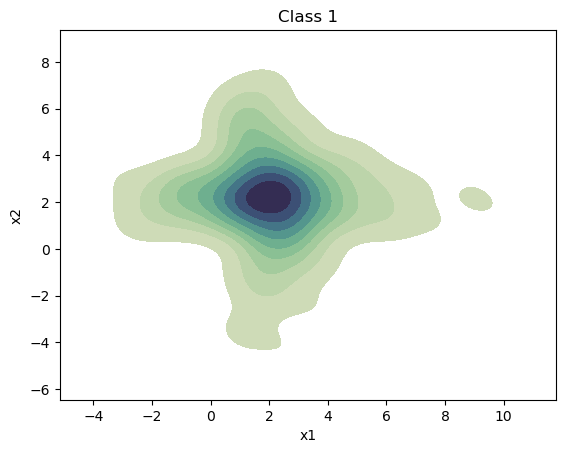

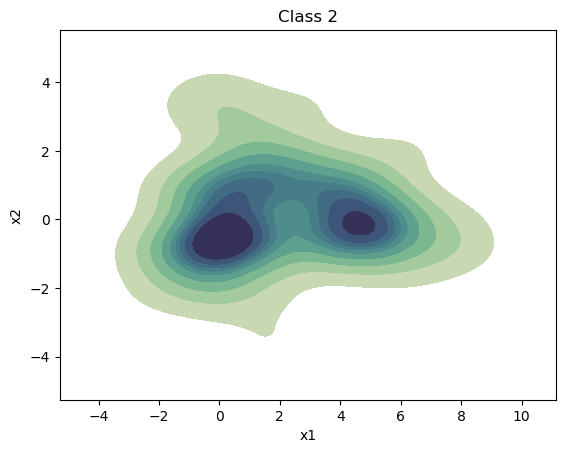

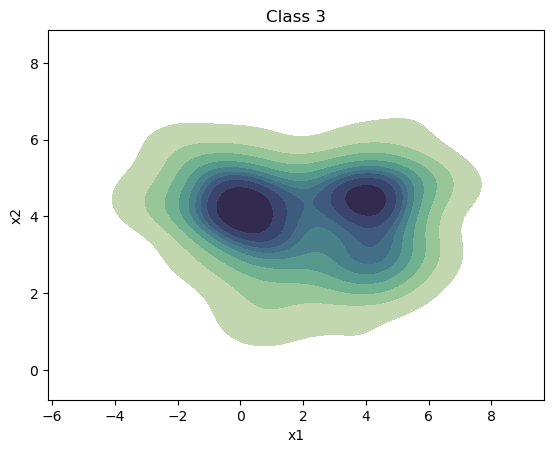

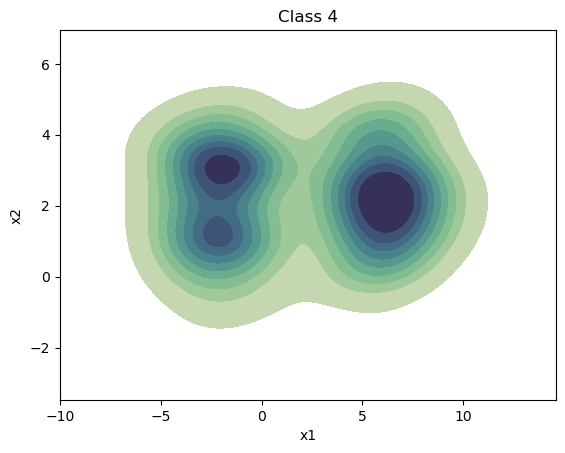

In [79]:
for class_index in data['label'].unique():
    data_class = data[data['label'] == class_index]
    s = sns.kdeplot(data=data_class, x='x1', y='x2', bw_method='silverman', 
                    fill=True, cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True))
    plt.title(f'Class {class_index}')
    plt.show()

### Other plots

In [137]:
def get_silverman_bandwidth(X):
    """Silverman's rule of thumb for kernel density estimation"""
    return (X.shape[0] * (X.shape[1] + 2) / 4.) ** (-1. / (X.shape[1] + 4))

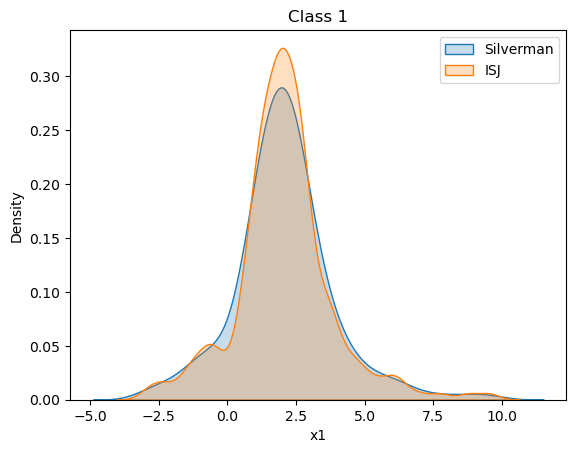

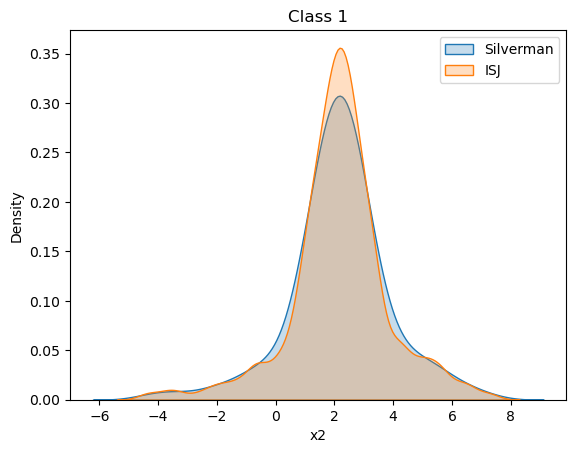

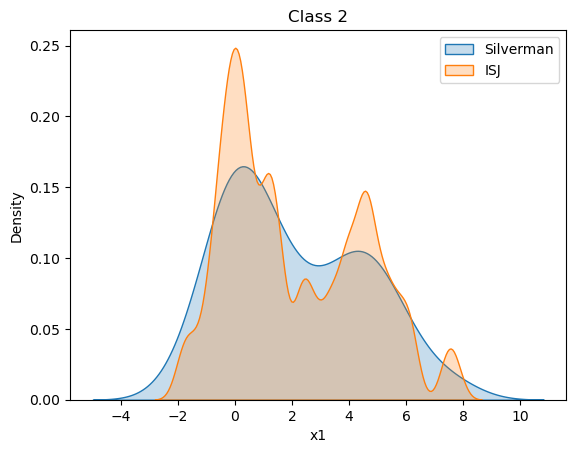

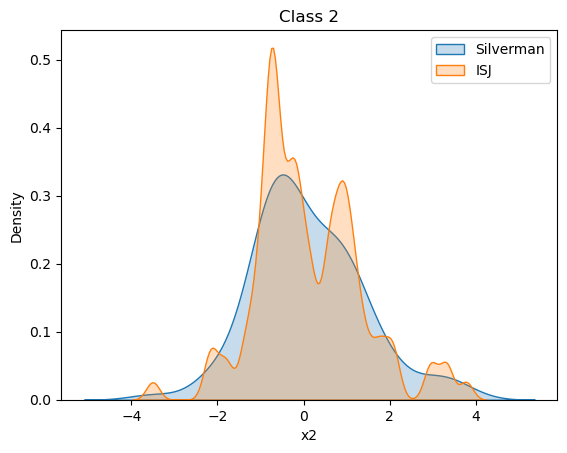

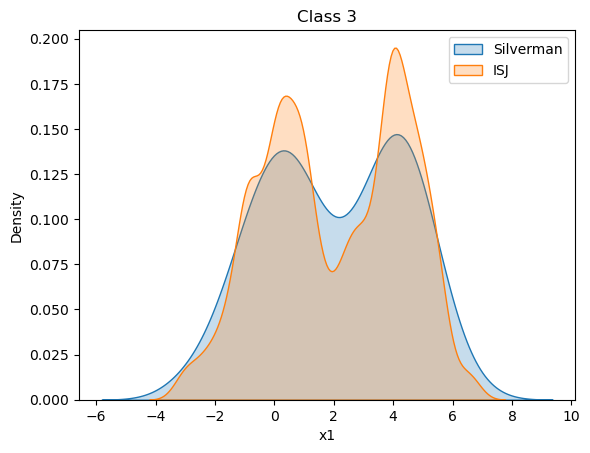

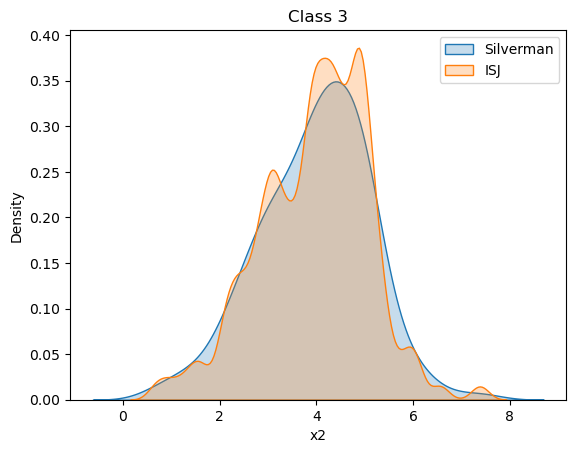

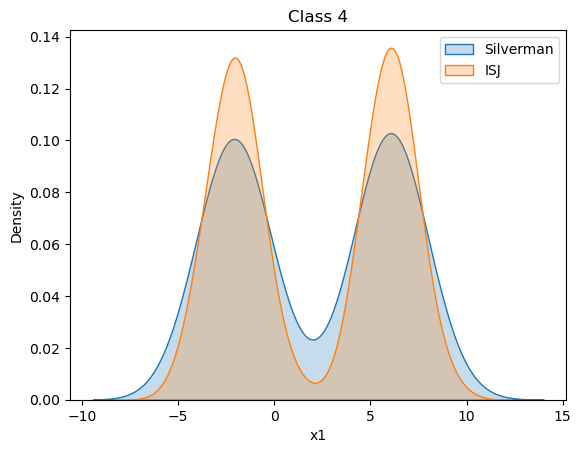

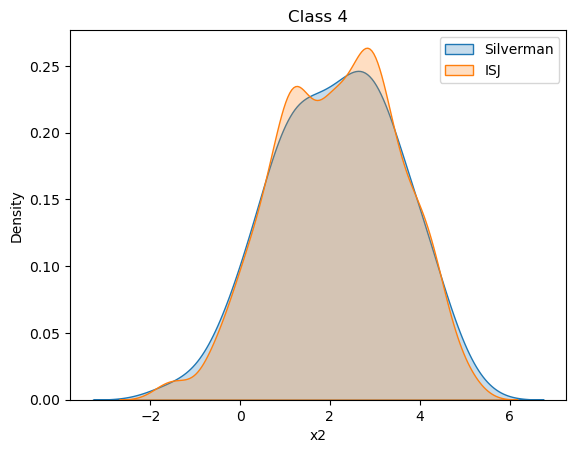

In [78]:
for class_index in data['label'].unique():
    data_class = data[data['label'] == class_index]
    s = sns.kdeplot(data=data_class, x='x1', bw_method='silverman', fill=True, cmap='BrBG', label='Silverman')
    isj = sns.kdeplot(data=data_class, x='x1', bw_method=improved_sheather_jones(data_class['x2'].values.reshape(-1,1)), fill=True, cmap='Blues', label='ISJ')
    plt.legend()
    plt.title(f'Class {class_index}')
    plt.show()
    s = sns.kdeplot(data=data_class, x='x2', bw_method='silverman', fill=True, cmap='BrBG', label='Silverman')
    isj = sns.kdeplot(data=data_class, x='x2', bw_method=improved_sheather_jones(data_class['x2'].values.reshape(-1,1)), fill=True, cmap='Blues', label='ISJ')
    plt.legend()
    plt.title(f'Class {class_index}')
    plt.show()

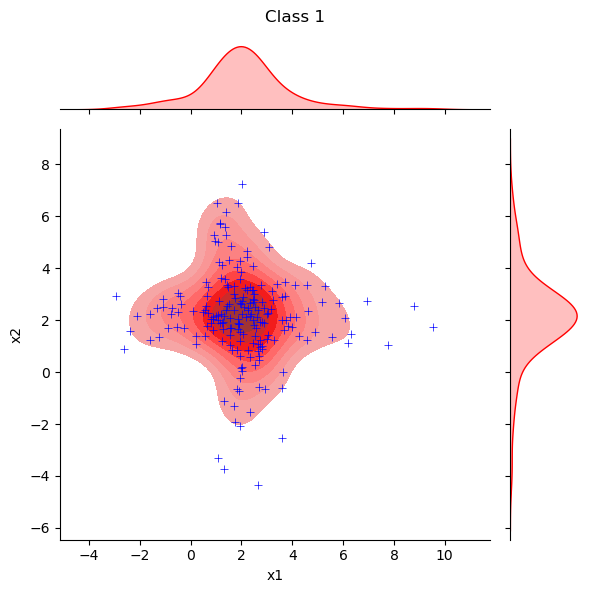

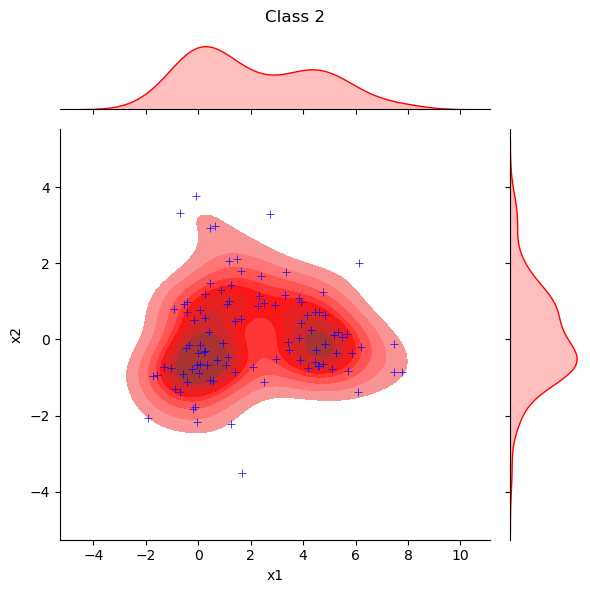

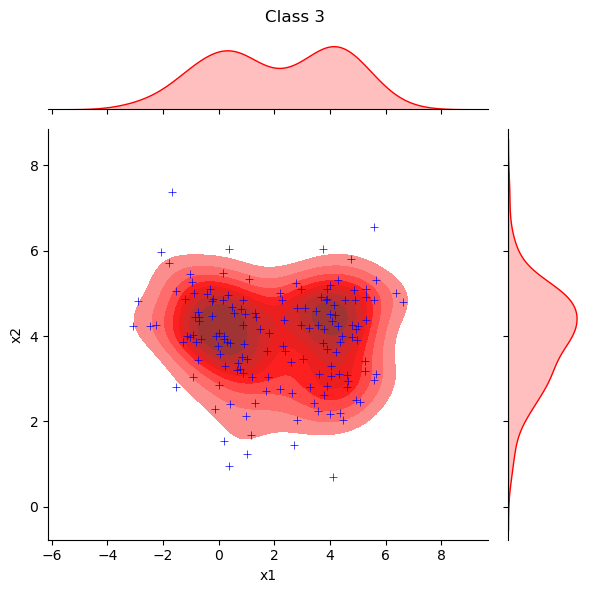

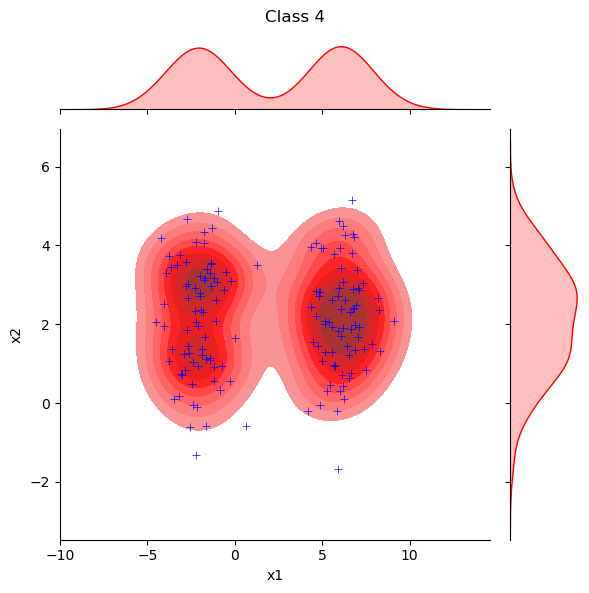

In [130]:
for class_index in data['label'].unique():
    class_data = data[data['label'] == class_index]
    p = sns.jointplot(x='x1', y='x2', data=class_data, kind='kde', fill=True, 
                      color='r', bw_method='silverman')
    p.plot_joint(plt.scatter, c='b', s=30, linewidth=0.5, marker='+')
    p.fig.suptitle(f'Class {class_index}')
    p.ax_joint.collections[0].set_alpha(0)
    p.fig.tight_layout()
    plt.show();

## 5. Construct graphs of the dependence of the mean value and s.c.r. (by folds) of the accuracy (accuracy) of the trained Bayesian classifier on the training and test samples on the proportionality factor l (the ratio of the Parzen window width to the Silverman width). Determine the window width at which the Bayesian classifier has the highest accuracy on the training and test samples

In [243]:
def non_parametric_bayes_classifier(X:np.ndarray, kernels_dict: Dict[int, gaussian_kde]):
    probs = []
    for kde in kernels_dict.values():
        probs.append(kde.evaluate(X.T))
    probs = np.array(probs).T
    class_index = np.argmax(probs, axis=1) + 1
    
    return probs, class_index

In [273]:
parzen_bandwith = np.arange(0.001, 1.0, 0.001)

train_acc_per_h = []
test_acc_per_h = []
train_coeff = []
test_coeff = []
for p_h in tqdm(parzen_bandwith): 
    train_acc = []
    test_acc = []
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        kde_models_dict = {i : gaussian_kde(X_train[y_train == i].T, bw_method=p_h) 
                           for i in data.label.unique()}
        
        train_probs, train_pred = non_parametric_bayes_classifier(X_train, kde_models_dict)
        test_probs, test_pred = non_parametric_bayes_classifier(X_test, kde_models_dict)
        
        train_acc.append(np.mean([train_pred[j] == y_train[j] for j in range(len(y_train))]))
        test_acc.append(np.mean([test_pred[j] == y_test[j] for j in range(len(y_test))]))
    
    train_acc_per_h.append(train_acc)
    test_acc_per_h.append(test_acc)
    train_coeff.append(p_h/get_silverman_bandwidth(X_train))
    test_coeff.append(p_h/get_silverman_bandwidth(X_test))

mean_train_acc = np.nanmean(np.array(train_acc_per_h), axis=1)
std_train_acc = np.nanstd(np.array(train_acc_per_h), axis=1)
mean_test_acc = np.nanmean(np.array(test_acc_per_h), axis=1)
std_test_acc = np.nanstd(np.array(test_acc_per_h), axis=1)
print(f'Train Accuracy {np.max(mean_train_acc):.3f} \u00B1 {std_train_acc[np.argmax(mean_train_acc)]:.3f}', '\n',
      f'Test Accuracy {np.max(mean_test_acc):.3f} \u00B1 {std_test_acc[np.argmax(mean_test_acc)]:.3f}\n',
      f'Best lambda {test_coeff[np.argmax(mean_test_acc)]}\n',
      f'Best parzen bandwith {test_coeff[np.argmax(mean_test_acc)] * get_silverman_bandwidth(X_test)}',
      sep='')     

  0%|          | 0/999 [00:00<?, ?it/s]

Train Accuracy 1.000 ± 0.000
Test Accuracy 0.703 ± 0.028
Best lambda 0.6085282864295372
Best parzen bandwith 0.274


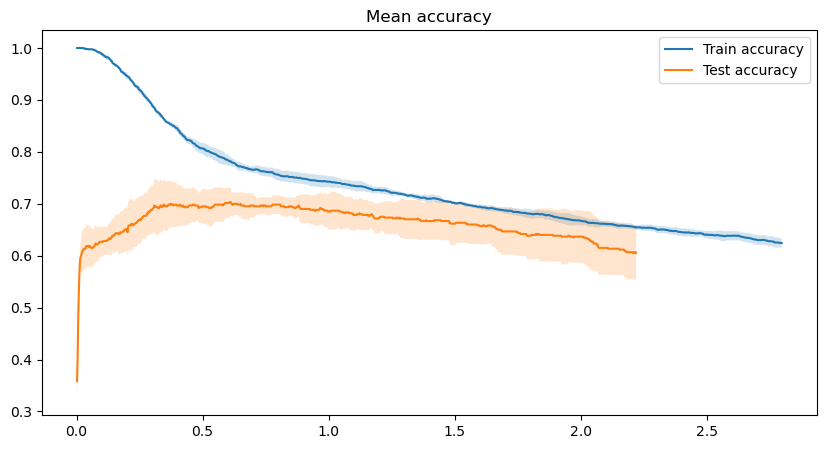

In [274]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train_coeff, mean_train_acc, label="Train accuracy")
ax.fill_between(train_coeff, mean_train_acc - std_train_acc,
                mean_train_acc + std_train_acc, alpha = 0.2)
ax.plot(test_coeff, mean_test_acc, label="Test accuracy")
ax.fill_between(test_coeff, mean_test_acc - std_test_acc,
                mean_test_acc + std_test_acc, alpha = 0.2)
ax.legend()
ax.set_title("Mean accuracy")
plt.show();

In [275]:
print(get_silverman_bandwidth(X[:(len(X) - len(X)//5)]))
print(get_silverman_bandwidth(X))
print(get_silverman_bandwidth(X[:(len(X) - len(X)//5)].reshape(-1,1)))
print(improved_sheather_jones(X[:(len(X) - len(X)//5)].reshape(-1,1)))

0.3573768861192045
0.3443299437308187
0.26824615199994184
0.2805737966652924


## 6. Draw conclusions about the accuracy of parametric and non-parametric Bayesian classification.

Due to the fact that only the first class has a normal distribution of features, the normality assumption is not met and parametric Bayesian classification gives poor results. In order to obtain distributions that describe the original data we use kernel density estimation. As mentioned above, the Silverman method for window width selection is also not suitable for non-normally distributed data, so window width grid search gives a different result.

В силу того, что только первый класс имеет нормальное распределение признаков, не выполняется предположение о нормальности и параметрическая байесовская классификация дает плохой результат. Чтобы получить распределения которые описывают исходные данные мы используем ядерную оценку плотности. Как указывалось выше метод сильвермана для подбора ширины окна, так же не подходит для данных не распределенных нормально, поэтому подбор ширины окна дает другой результат.